In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


path2 =  "/Users/tomelder//Downloads/Downloads 2024/vdjdb-2023-06-01/vdjdb_full.txt"
data = pd.read_csv(path2, sep='\t')
df = pd.DataFrame(data)

# Filtering to only humdan.
df = df[df['species'] == 'HomoSapiens']

df_filter = df[(df['vdjdb.score'] == 2) | (df['vdjdb.score'] == 3) | (df['vdjdb.score'] == 4)  | (df['vdjdb.score'] == 1) ]

print(len(df_filter))


relevant_columns = [
    'cdr3.alpha', 'v.alpha', 'j.alpha', 'cdr3.beta', 'v.beta', 'd.beta', 'j.beta',
    'species', 'mhc.a', 'mhc.b', 'antigen.gene','antigen.epitope', 'vdjdb.score', 'mhc.class'
]
# For the purpose of this example, we won't filter out lower-quality scores to avoid data imbalance,
# but in practice, you may want to consider this based on the dataset's size and distribution.
unfiltered_data = df[relevant_columns]

filtered_data = df_filter[relevant_columns]

# Checking for missing values in crucial columns
missing_values_un = unfiltered_data.isnull().sum()
missing_values = filtered_data.isnull().sum()

# Examining the number of unique values in categorical columns for potential encoding strategies
unique_values_un = unfiltered_data.nunique()
unique_values = filtered_data.nunique()

# Removing rows with missing cdr3 sequences
df_cleaned_un = unfiltered_data.dropna(subset=['cdr3.alpha','cdr3.beta'])
df_cleaned_un.reset_index(drop=True, inplace=True)

df_cleaned = filtered_data.dropna(subset=['cdr3.alpha','cdr3.beta'])
df_cleaned.reset_index(drop=True, inplace=True)

missing_values_df_cleaned_un = df_cleaned_un.isnull().sum()
report = {
    "Missing Values for oringinal unfiltered dataset": missing_values_un,
    "Missing Values df_cleaned_un": missing_values_df_cleaned_un
}

missing_values_df_cleaned = df_cleaned.isnull().sum()
report = {
    "Missing Values for oringinal filtered dataset": missing_values,
    "Missing Values df_cleaned": missing_values_df_cleaned
}


df_cleaned = df_cleaned.drop_duplicates()

df_cleaned_un = df_cleaned_un.drop_duplicates()

print(len(df_cleaned), 'length of filtered dataset')
print(len(df_cleaned_un), 'length of unfiltered dataset')


report  


7542
1714 length of filtered dataset
27730 length of unfiltered dataset


/var/folders/y8/_g3b_hys2dncxdddn9qg56100000gn/T/ipykernel_50035/3072739990.py:8: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path2, sep='\t')


{'Missing Values for oringinal filtered dataset': cdr3.alpha         4631
 v.alpha            4629
 j.alpha            4760
 cdr3.beta           871
 v.beta              867
 d.beta             6480
 j.beta              942
 species               0
 mhc.a                 0
 mhc.b                 0
 antigen.gene         28
 antigen.epitope       0
 vdjdb.score           0
 mhc.class             0
 dtype: int64,
 'Missing Values df_cleaned': cdr3.alpha            0
 v.alpha               0
 j.alpha              99
 cdr3.beta             0
 v.beta                0
 d.beta             1737
 j.beta               74
 species               0
 mhc.a                 0
 mhc.b                 0
 antigen.gene         28
 antigen.epitope       0
 vdjdb.score           0
 mhc.class             0
 dtype: int64}

### We now have two different datasets, both containing only rows with cdr3 alpha AND beta. This needs to be done seperately with both the alpha and beta. Lets look at the epitope-cdr3 relationships inside the data.

there are 341 unique epitopes in the filtered dataset
there are 913 unique epitopes in the unfiltered dataset


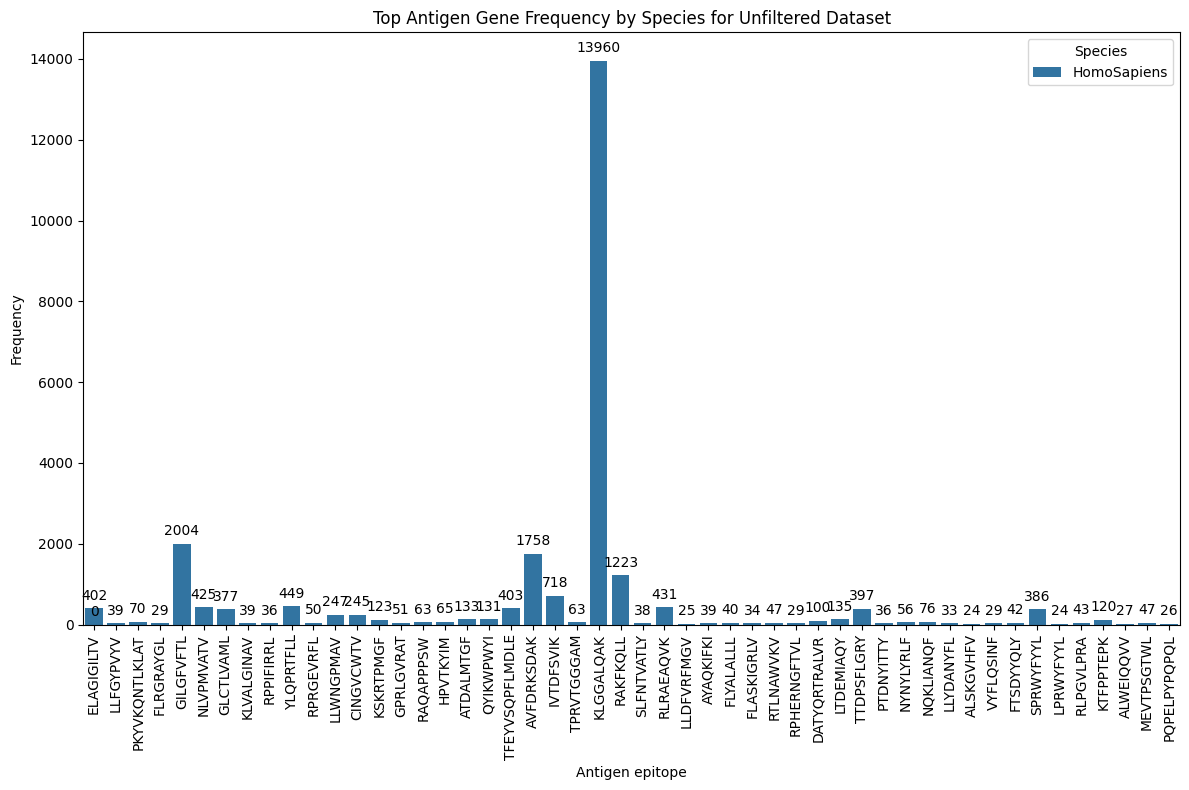

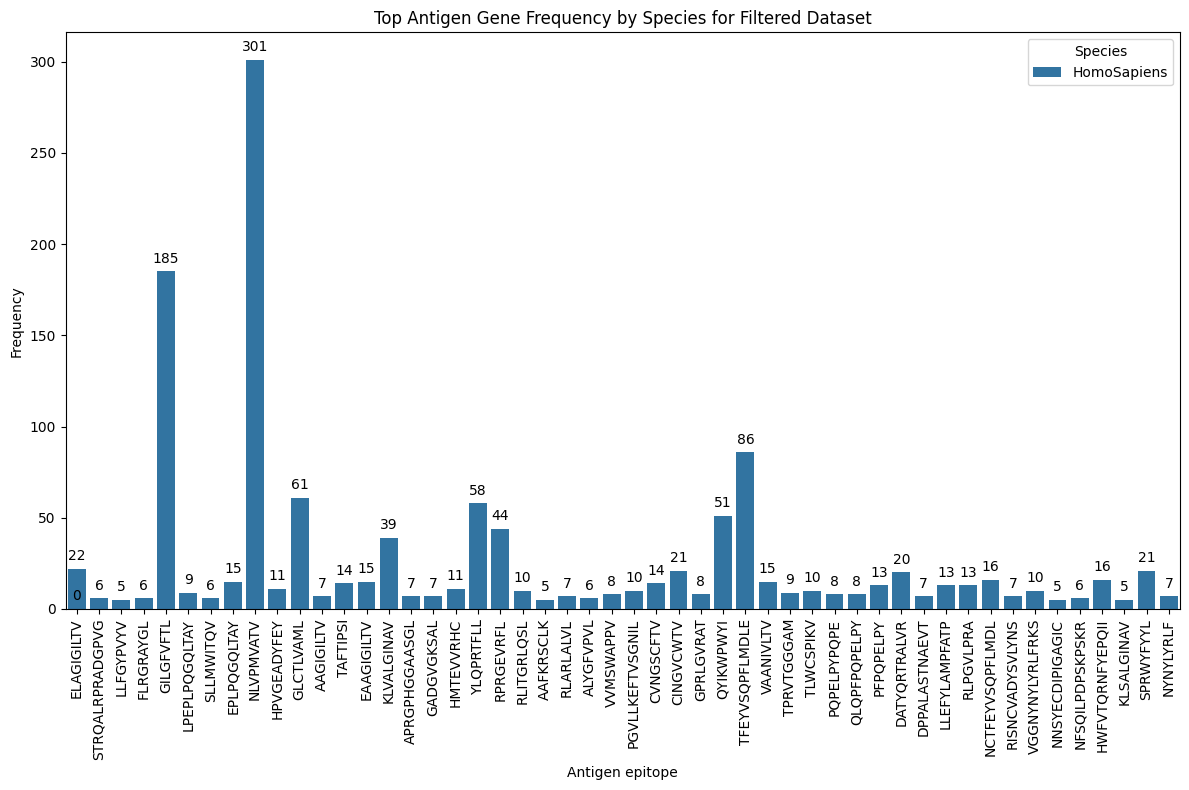

In [3]:
print('there are',len(df_cleaned['antigen.epitope'].unique()), 'unique epitopes in the filtered dataset')
print('there are',len(df_cleaned_un['antigen.epitope'].unique()), 'unique epitopes in the unfiltered dataset')

top_n = 50  # Show top 20 categories
top_antigen_genes = df_cleaned_un['antigen.epitope'].value_counts().head(top_n).index
df_top_antigens = df_cleaned_un[df_cleaned_un['antigen.epitope'].isin(top_antigen_genes)]

plt.figure(figsize=(12, 8))  # Increase plot size
ax = sns.countplot(x='antigen.epitope', hue='species', data=df_top_antigens)
plt.title('Top Antigen Gene Frequency by Species for Unfiltered Dataset')
plt.xlabel('Antigen epitope')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate labels
plt.legend(title='Species')
plt.tight_layout()  # Adjust layout


# Adding the annotation to each bar
for p in ax.patches:
    height = p.get_height()
    if pd.notnull(height):  # Check if the height is not NaN
        ax.annotate(f'{int(height)}', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points')


top_n = 50  # Show top 20 categories
top_antigen_genes = df_cleaned['antigen.epitope'].value_counts().head(top_n).index
df_top_antigens = df_cleaned[df_cleaned['antigen.epitope'].isin(top_antigen_genes)]
plt.figure(figsize=(12, 8))  # Increase plot size
ax = sns.countplot(x='antigen.epitope', hue='species', data=df_top_antigens)
plt.title('Top Antigen Gene Frequency by Species for Filtered Dataset')
plt.xlabel('Antigen epitope')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate labels
plt.legend(title='Species')
plt.tight_layout()  # Adjust layout


# Adding the annotation to each bar
for p in ax.patches:
    height = p.get_height()
    if pd.notnull(height):  # Check if the height is not NaN
        ax.annotate(f'{int(height)}', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points')




Interesting that the most populus epitope in the Unfiltered dataset does not make an appearance in the top 50 epitopes of the filtered dataset. Why ?. The second most populus does make an appearance. 

A problem with the supervised learning approach is the presence of unseen epitopes in the test set. The non generative models we are applying are not suited to make predictions on these epitopes, so will get them wrong 100% of the time. We can filter out epitopes that only bind to a small number of tcrs. 

In [4]:
def filter_by_epitope_frequency(dataframe, column_name, threshold):
    """
    Filters the provided DataFrame based on the frequency of appearances of values in a specified column.
    
    Args:
    dataframe (pd.DataFrame): The DataFrame to filter.
    column_name (str): The name of the column to filter by frequency.
    threshold (int): The minimum number of appearances for a value to be included in the filtered DataFrame.
    
    Returns:
    pd.DataFrame: A DataFrame filtered based on the frequency threshold.
    int: The number of unique values meeting the threshold.
    """
    # Count how many times each value appears
    value_counts = dataframe[column_name].value_counts()
    
    # Get the values that meet or exceed the threshold
    frequent_values = value_counts[value_counts > threshold].index
    
    # Filter the DataFrame to include only rows where the value appears at least 'threshold' times
    filtered_dataframe = dataframe[dataframe[column_name].isin(frequent_values)]
    
    # Count of unique values that meet the threshold
    unique_value_count = len(frequent_values)
    
    return filtered_dataframe, unique_value_count

df_cleaned_filt_by_5, count = filter_by_epitope_frequency(df_cleaned, 'antigen.epitope', 5)

df_cleaned_un_filt_by_50, count_un = filter_by_epitope_frequency(df_cleaned_un, 'antigen.epitope', 50)





df1 = df_cleaned
print(len(df1), 'df1')

df2 = df_cleaned_un
print(len(df2), ' df2')

df3 = df_cleaned_filt_by_5
print(len(df3), 'df3')

df4 = df_cleaned_un_filt_by_50
print(len(df4), 'df4')



1714 df1
27730  df2
1244 df3
24611 df4


We now have these datasets:

df1: Filtered by vdj score 1-4, cleaned by dropping rows without both cdr3 alpha and beta, dropped duplicates, currently filtered for just humans. 

df2: Not filtered using vdjscore, Cleaned by dropping rows without both cdr3 alpha and beta, dropped duplicates, currently filtered for just humans.

df3: Filtered by vdj score 1-4, cleaned by dropping rows without both cdr3 alpha and beta, dropped duplicates, currently filtered for just humans, Epitopes with less than 5 binding tcr dropped

df4: Not filtered using vdjscore, Cleaned by dropping rows without both cdr3 alpha and beta, dropped duplicates, currently filtered for just humans. Epitopes with less than 50 binding epitopes dropped.

Looking at the k-mer feature matrix

['ELAGIGILTV' 'STRQALRPRADGPVG' 'STRQALRPRADGPVG' ... 'QLQPFPQPELPY'
 'QLQPFPQPELPY' 'QLQPFPQPELPY']
{'AAGIGILTV': ['sfg'], 'ALYGFVPVL': [], 'APRGPHGGAASGL': [], 'CINGVCWTV': [], 'CVNGSCFTV': [], 'DATYQRTRALVR': [], 'DPPALASTNAEVT': [], 'EAAGIGILTV': [], 'ELAGIGILTV': [], 'EPLPQGQLTAY': ['dsn'], 'FLRGRAYGL': ['qyf', 'qay', 'gqa', 'aye', 'lgq'], 'GADGVGKSAL': ['pgt', 'ssd'], 'GILGFVFTL': [], 'GLCTLVAML': [], 'GPRLGVRAT': [], 'HMTEVVRHC': [], 'HPVGEADYFEY': ['ssa', 'ars', 'rsg'], 'HWFVTQRNFYEPQII': [], 'KLVALGINAV': [], 'LLEFYLAMPFATP': [], 'LPEPLPQGQLTAY': ['spg', 'asp'], 'NCTFEYVSQPFLMDL': [], 'NFSQILPDPSKPSKR': [], 'NLVPMVATV': [], 'NYNYLYRLF': ['qgy', 'gye'], 'PFPQPELPY': [], 'PGVLLKEFTVSGNIL': [], 'PQPELPYPQPE': [], 'QLQPFPQPELPY': [], 'QYIKWPWYI': [], 'RISNCVADYSVLYNS': [], 'RLARLALVL': [], 'RLITGRLQSL': [], 'RLPGVLPRA': [], 'RPRGEVRFL': [], 'SLLMWITQV': [], 'SPRWYFYYL': [], 'STRQALRPRADGPVG': ['gte', 'qhf', 'pqh', 'qpq', 'nqp', 'snq', 'tes', 'esn'], 'TAFTIPSI': ['tgg', 'slt', 'ltg

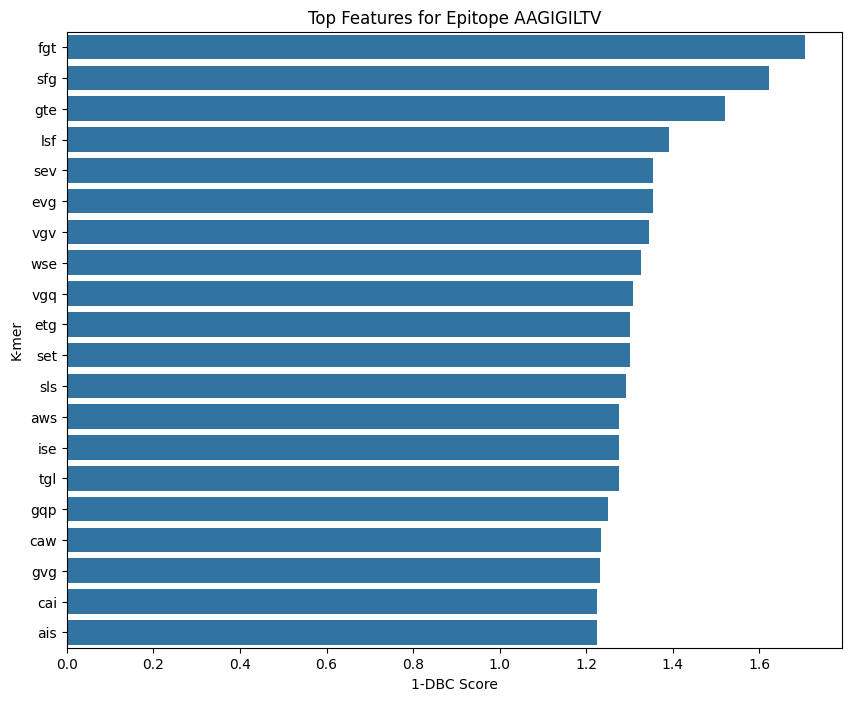

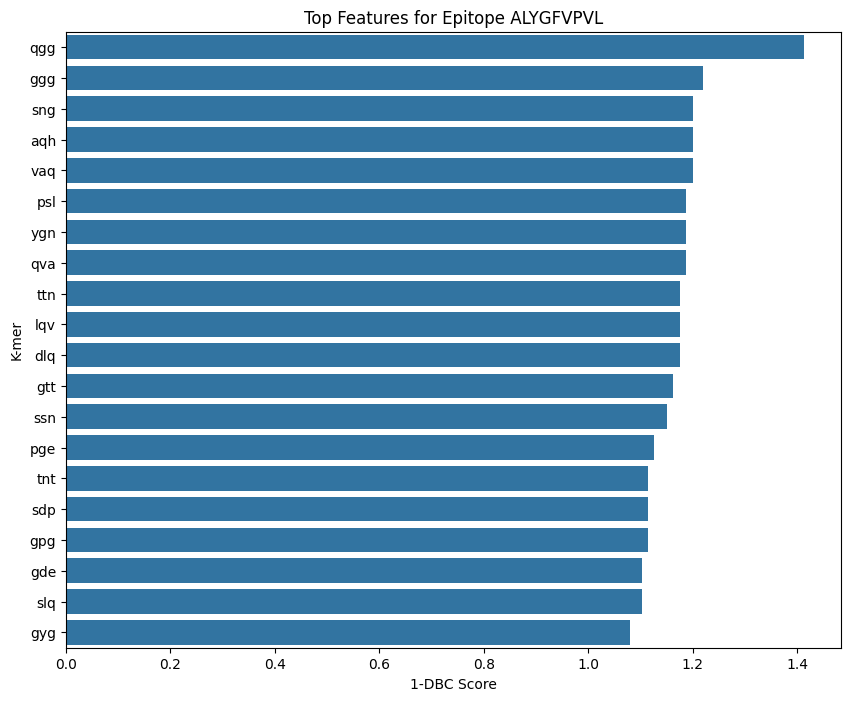

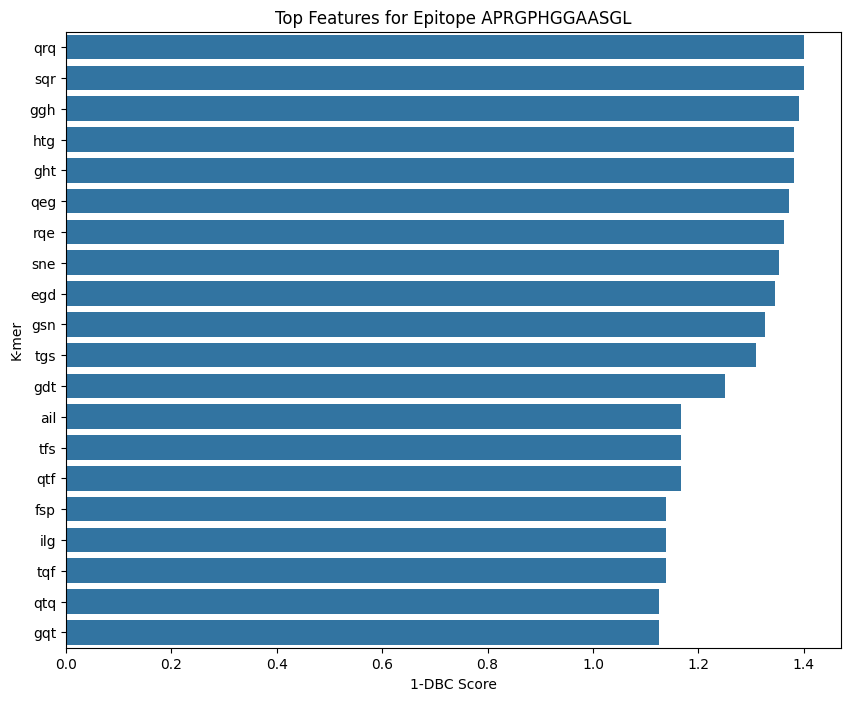

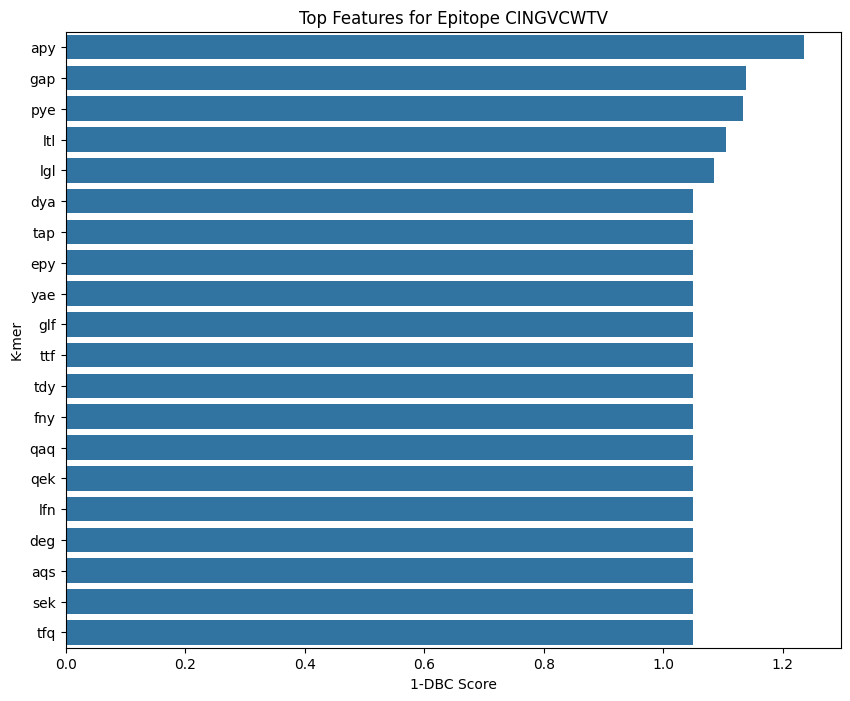

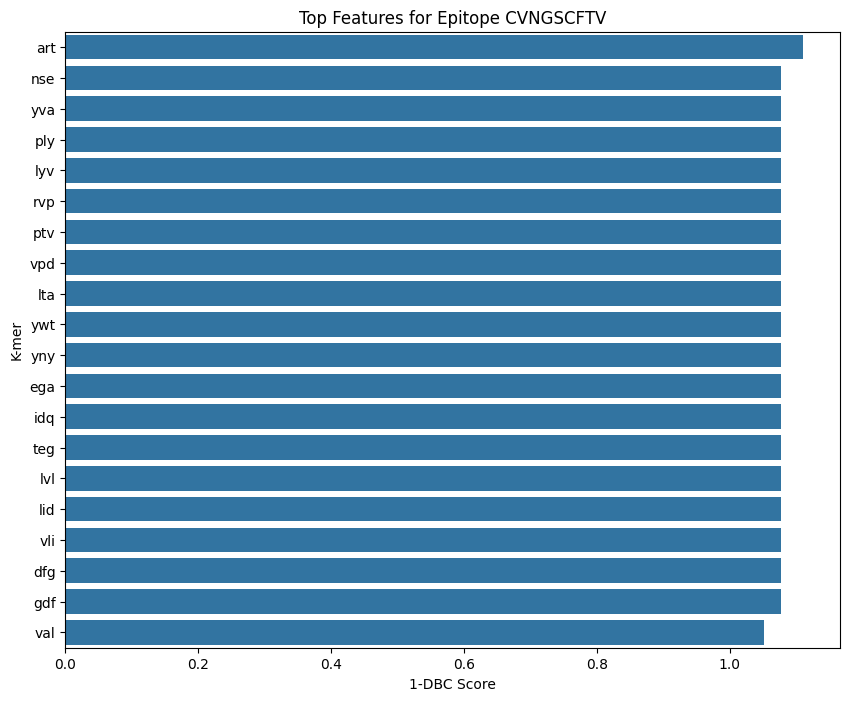

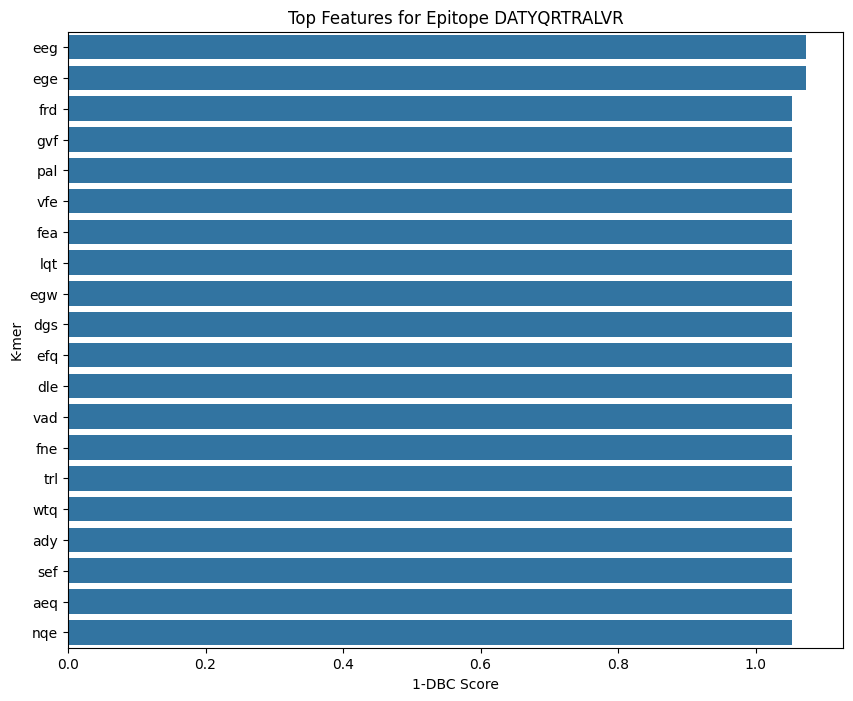

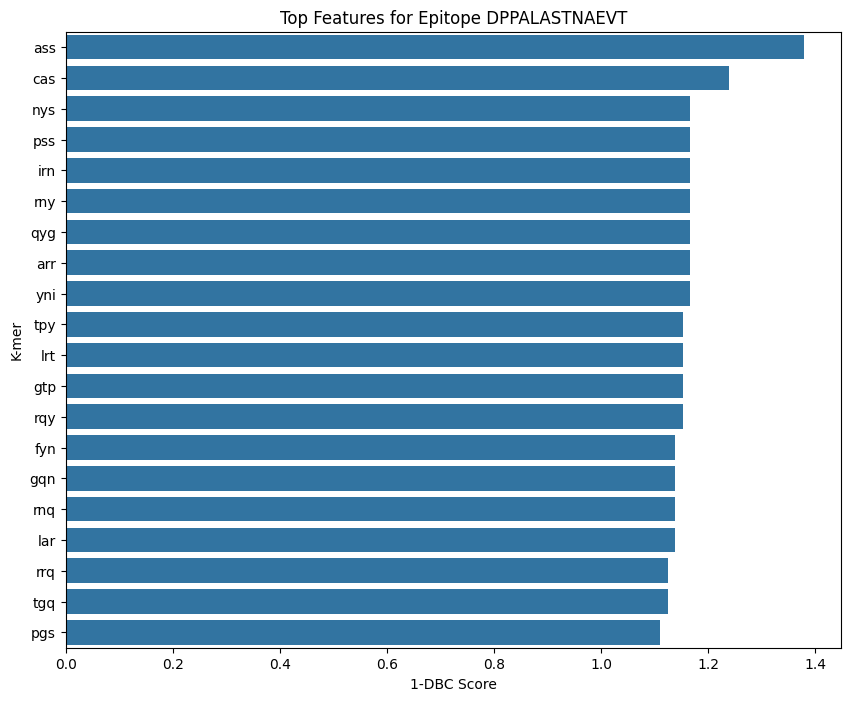

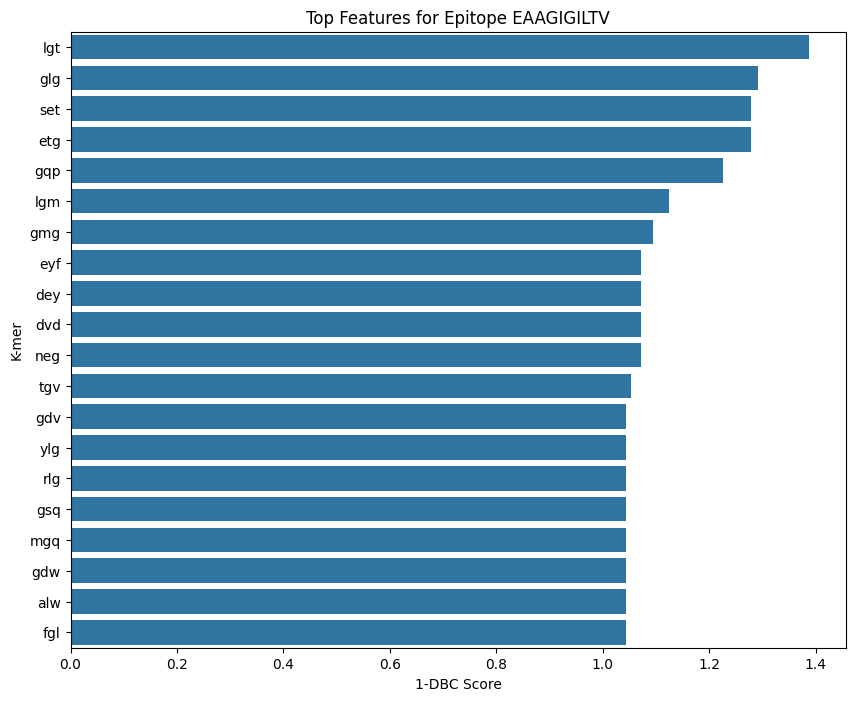

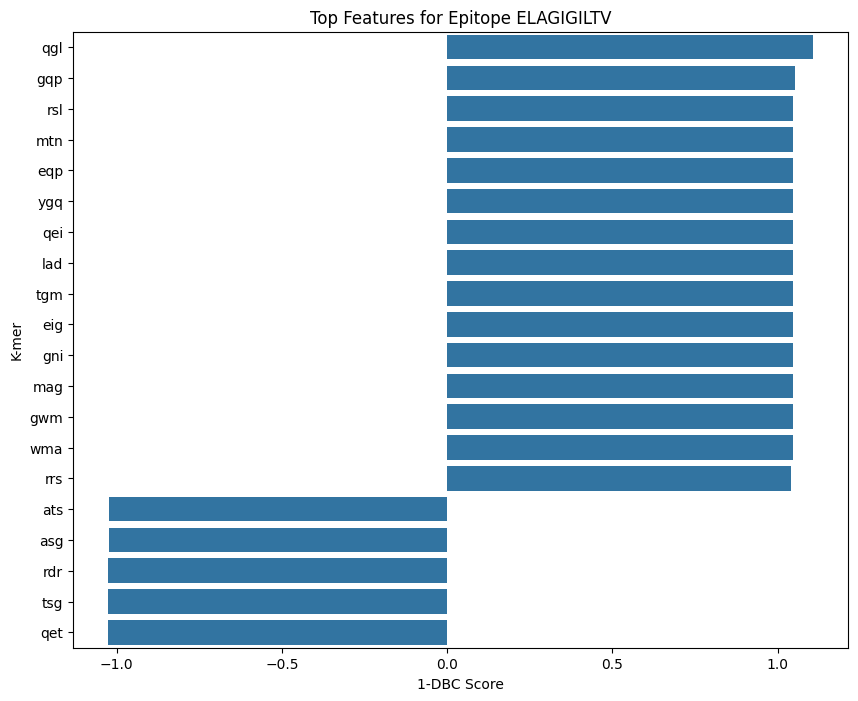

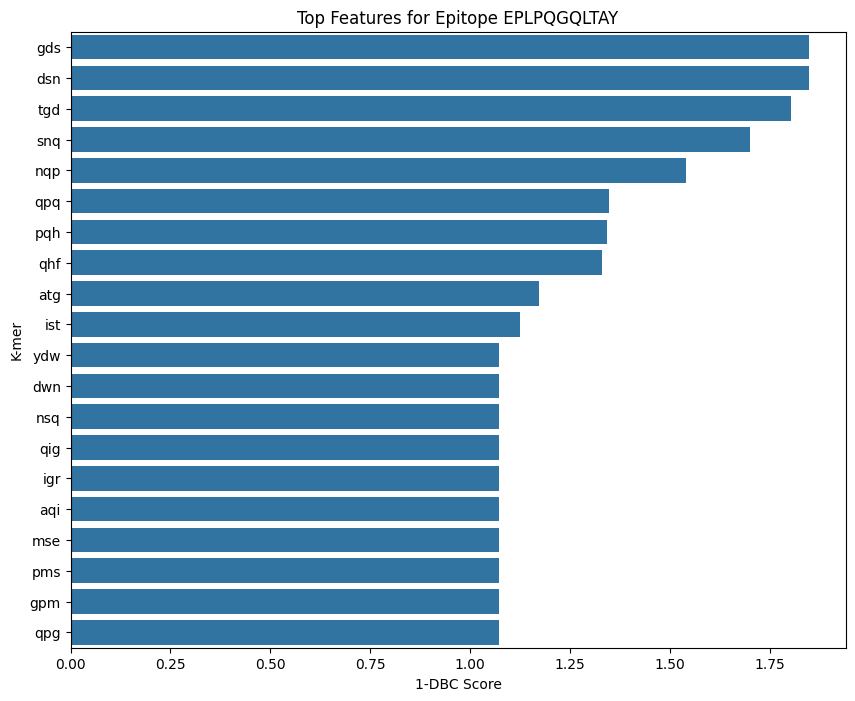

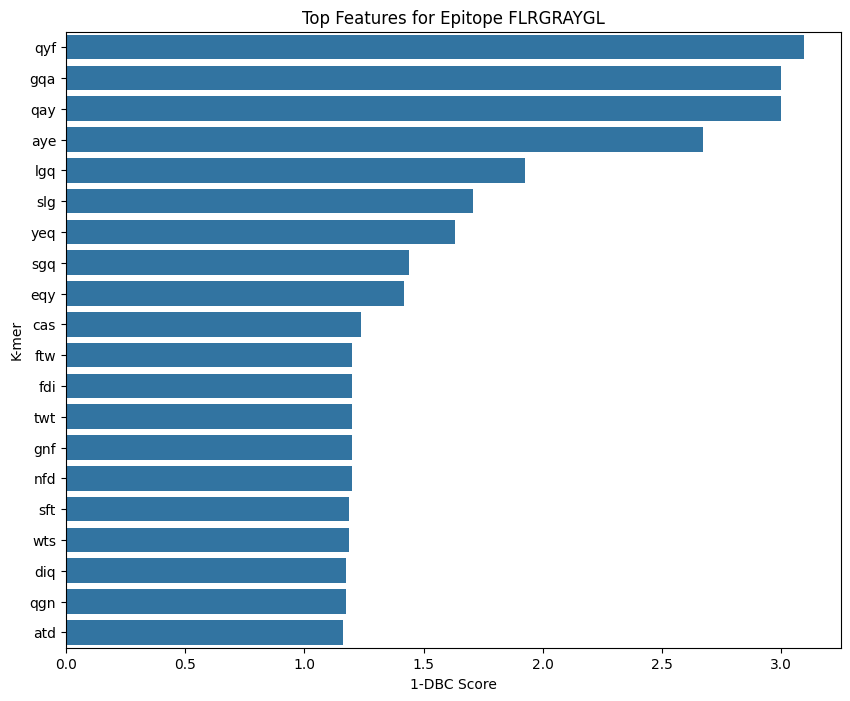

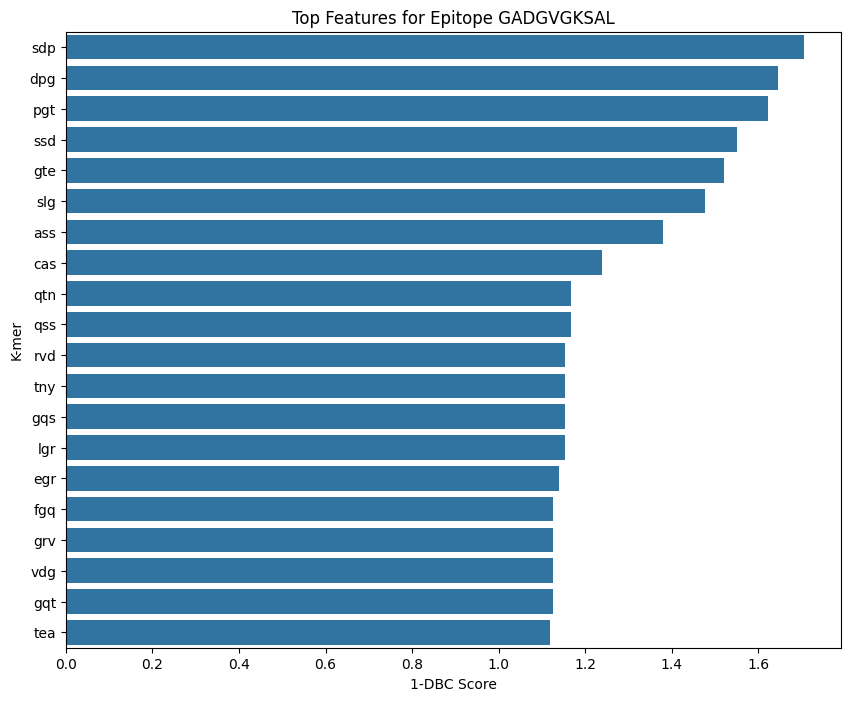

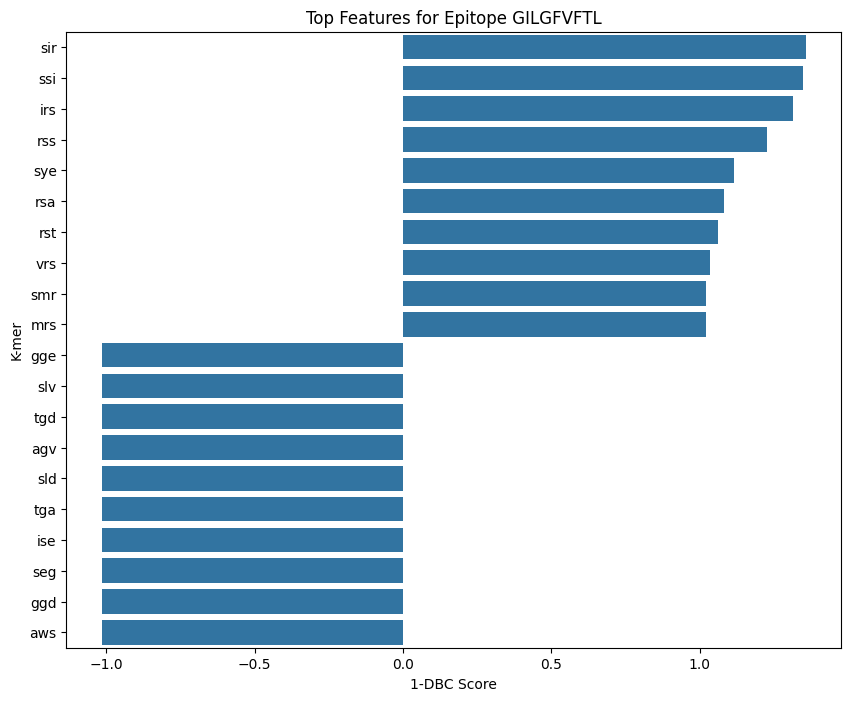

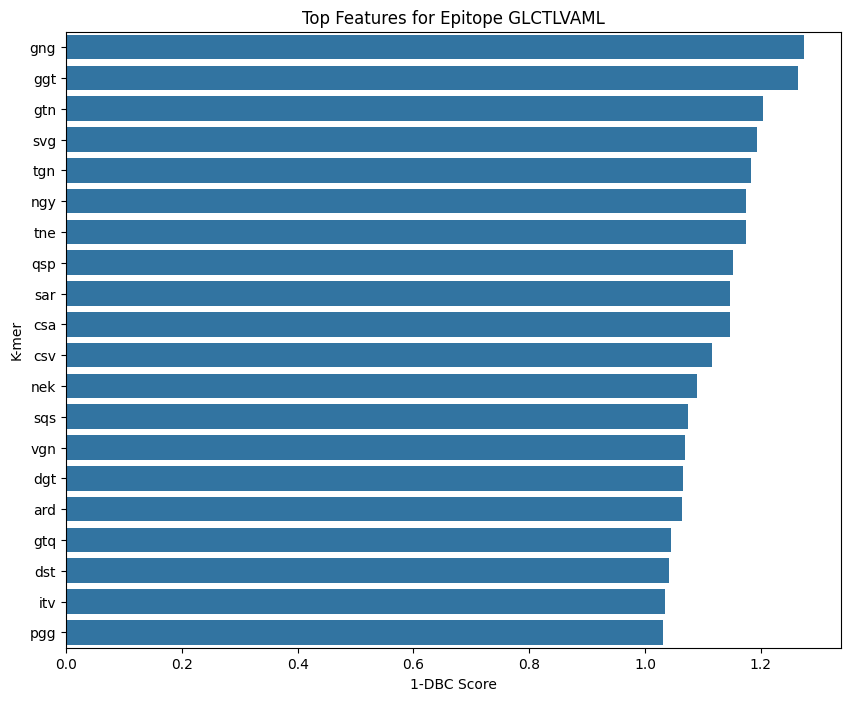

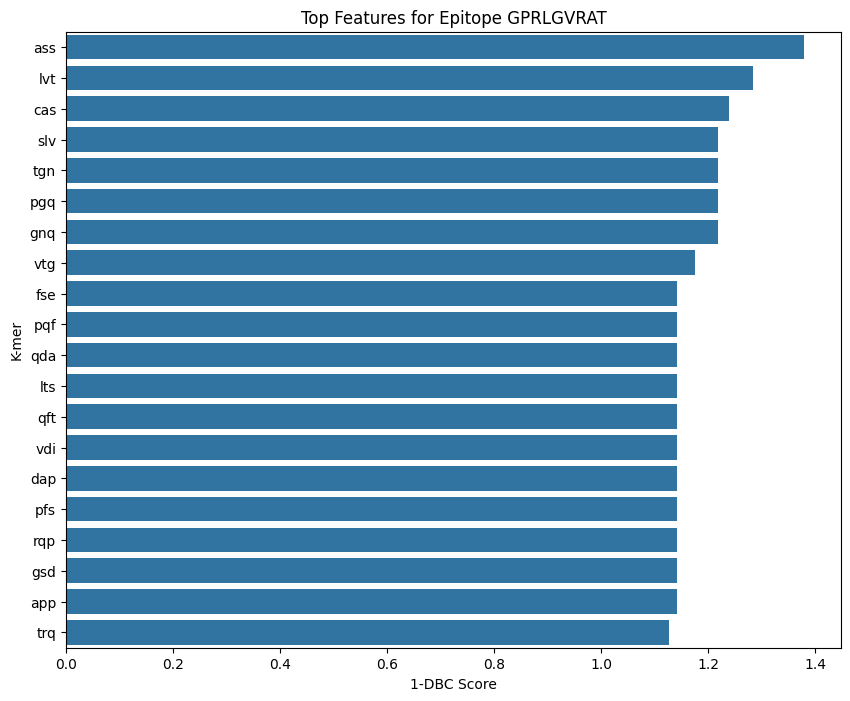

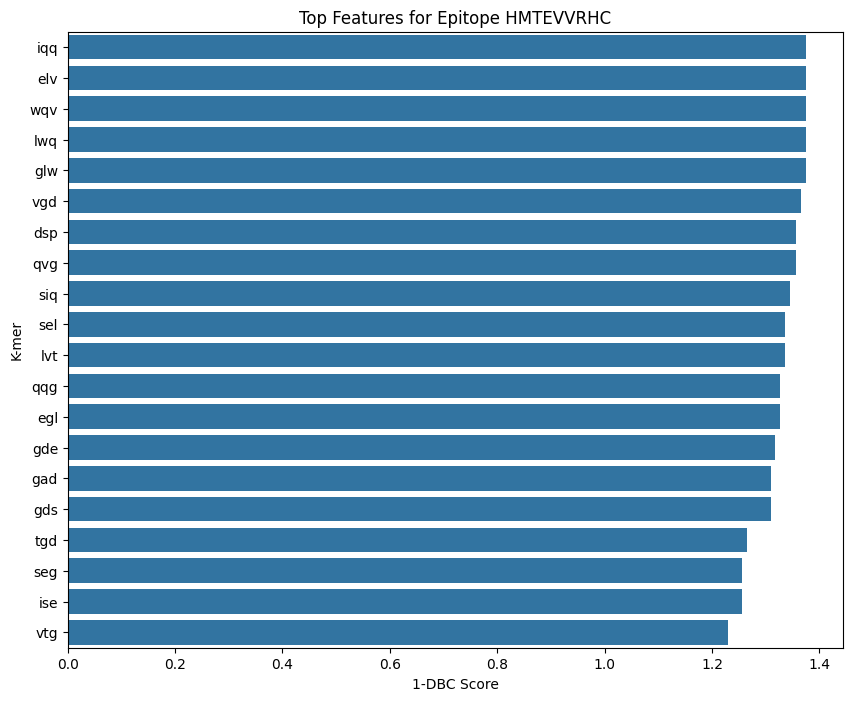

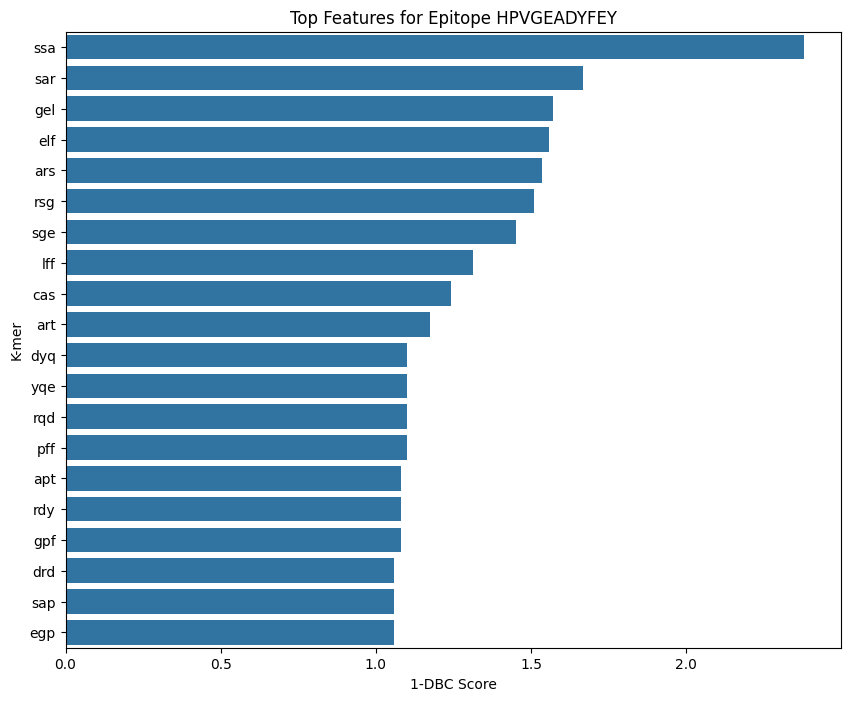

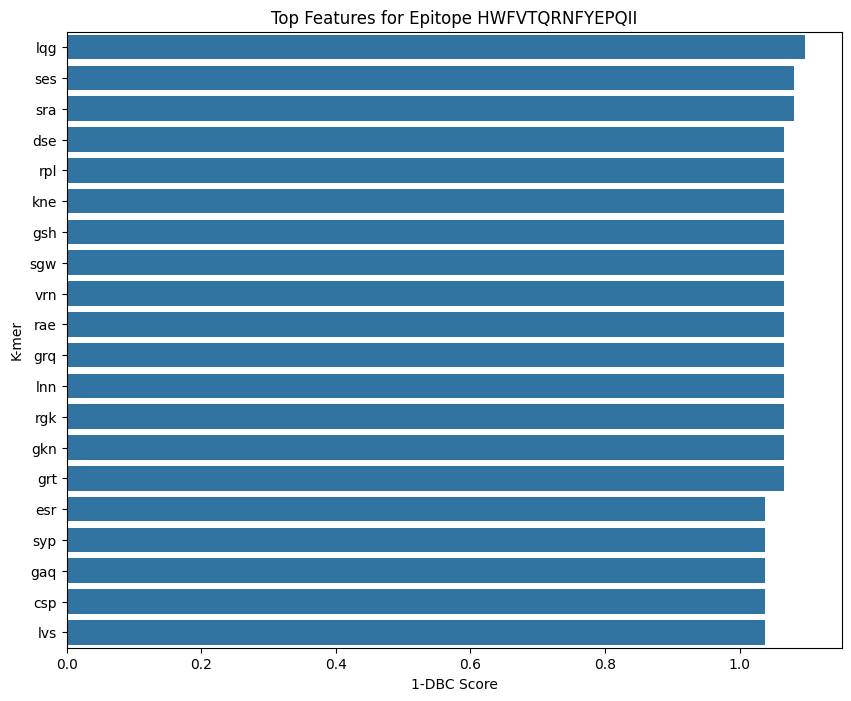

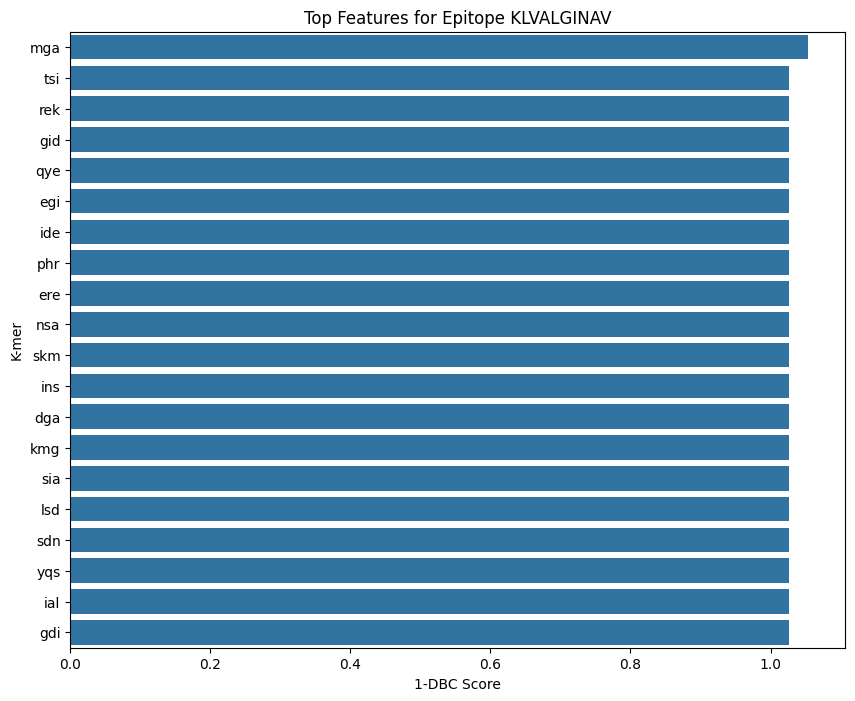

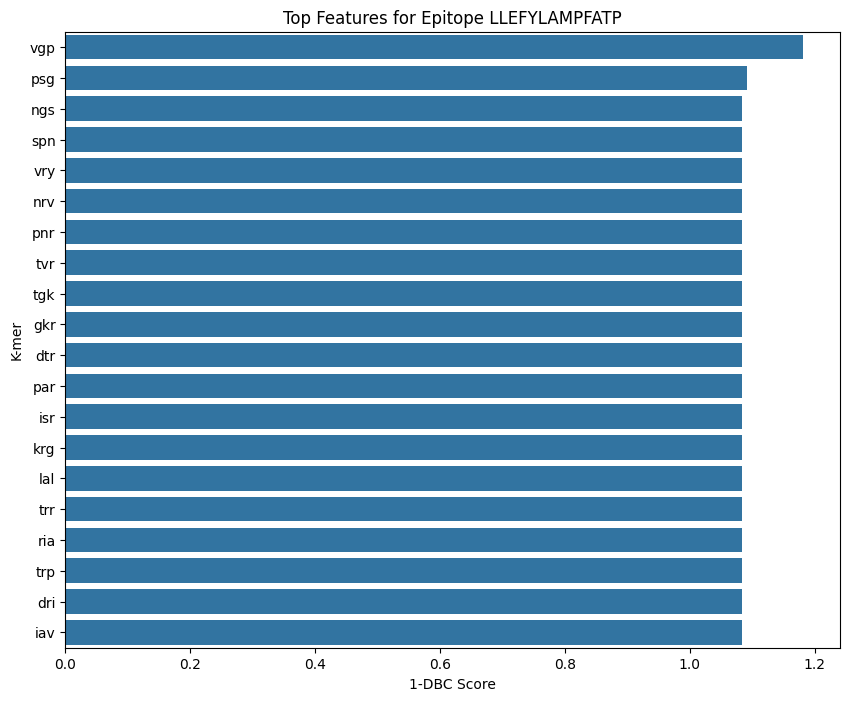

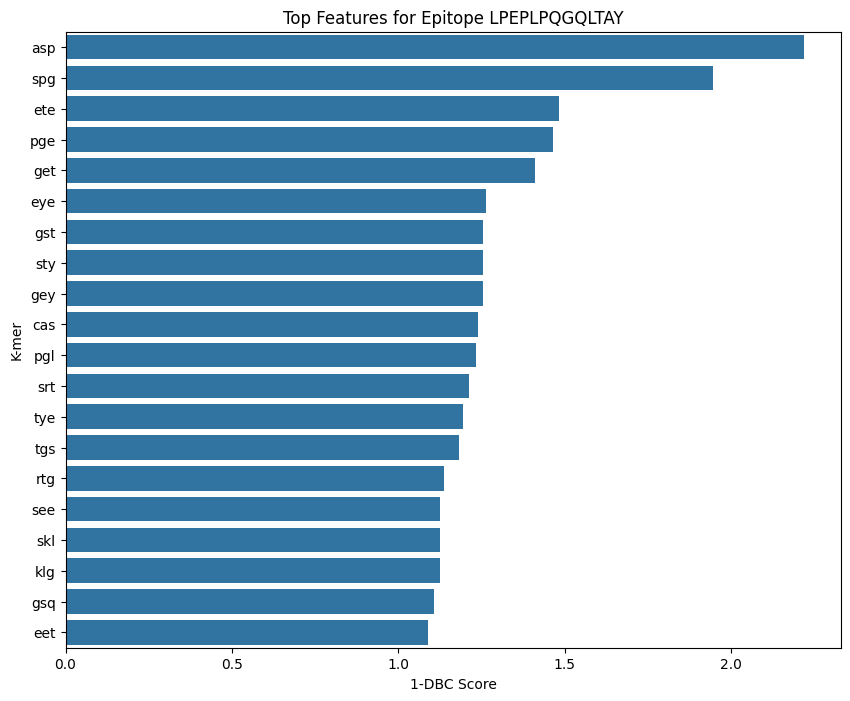

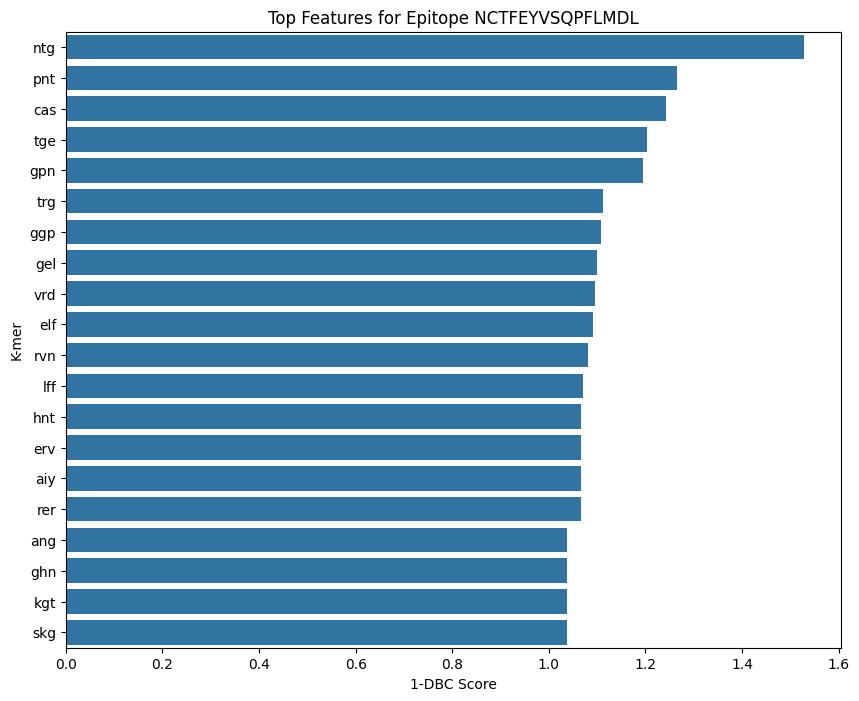

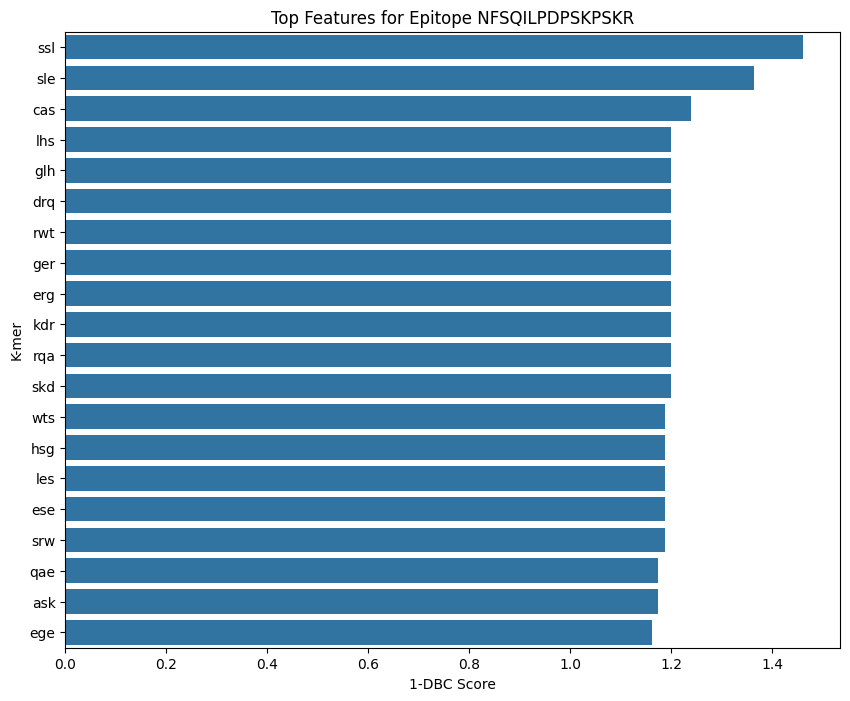

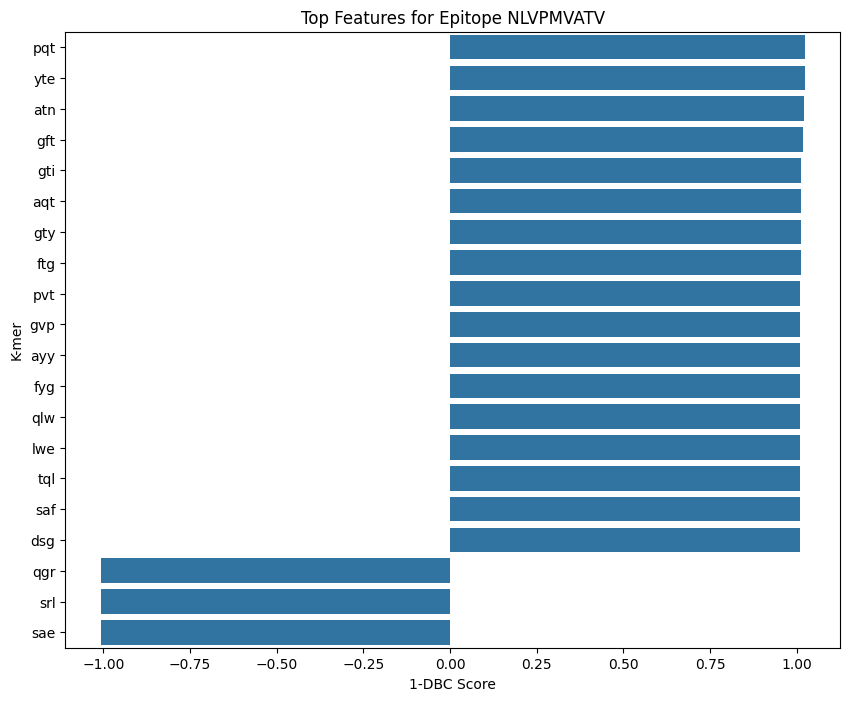

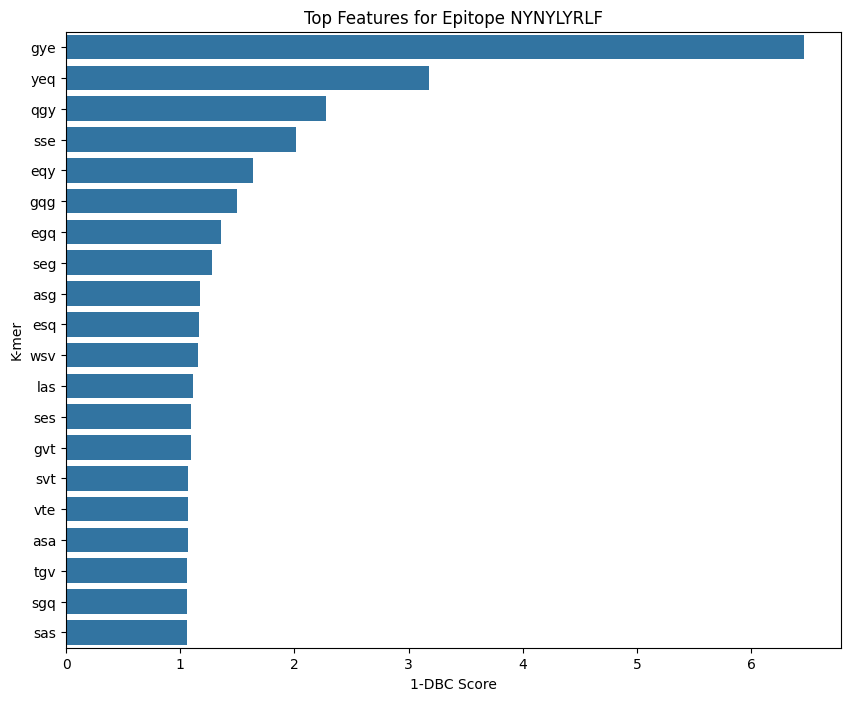

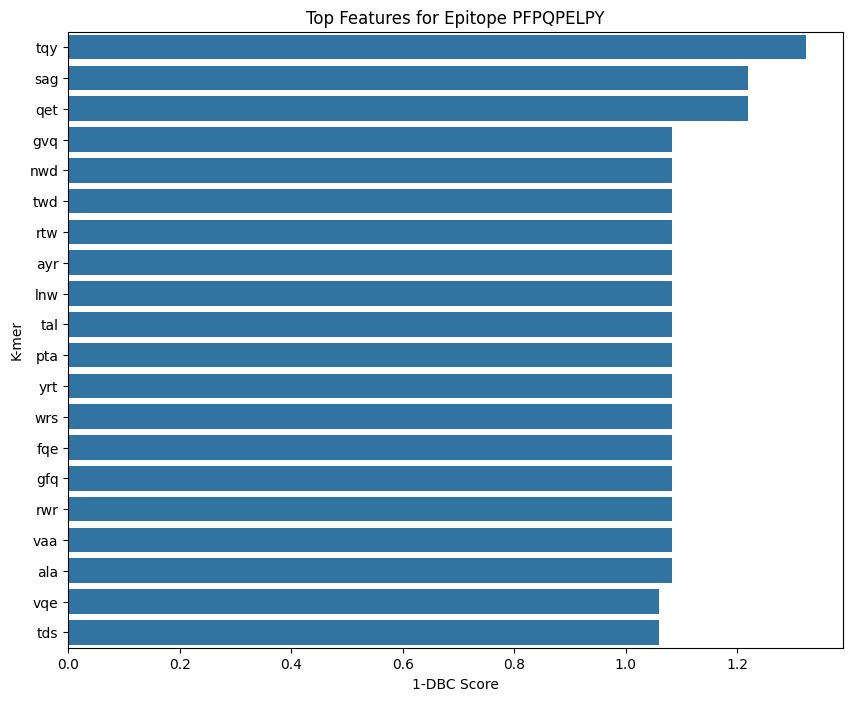

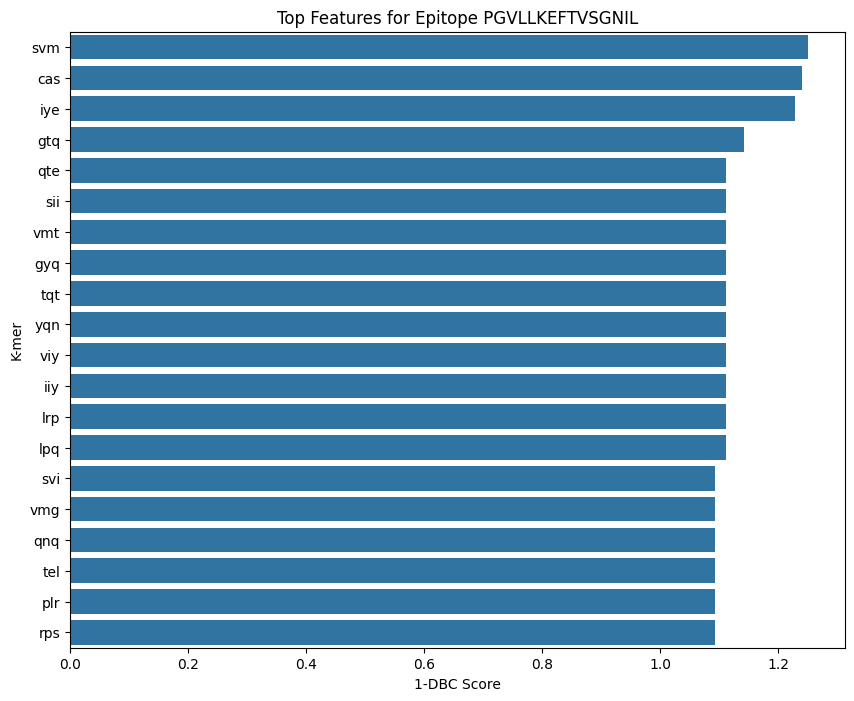

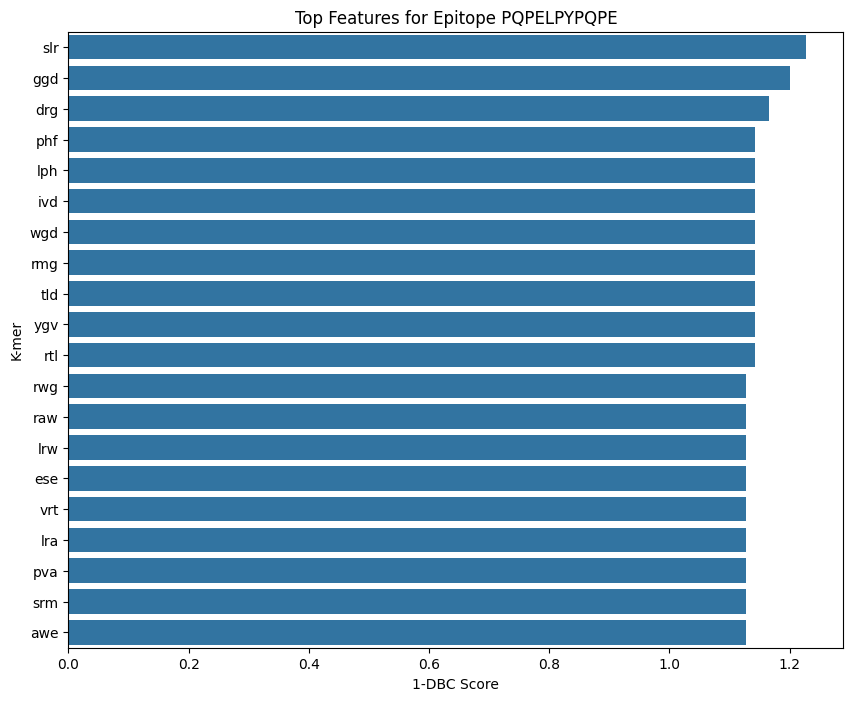

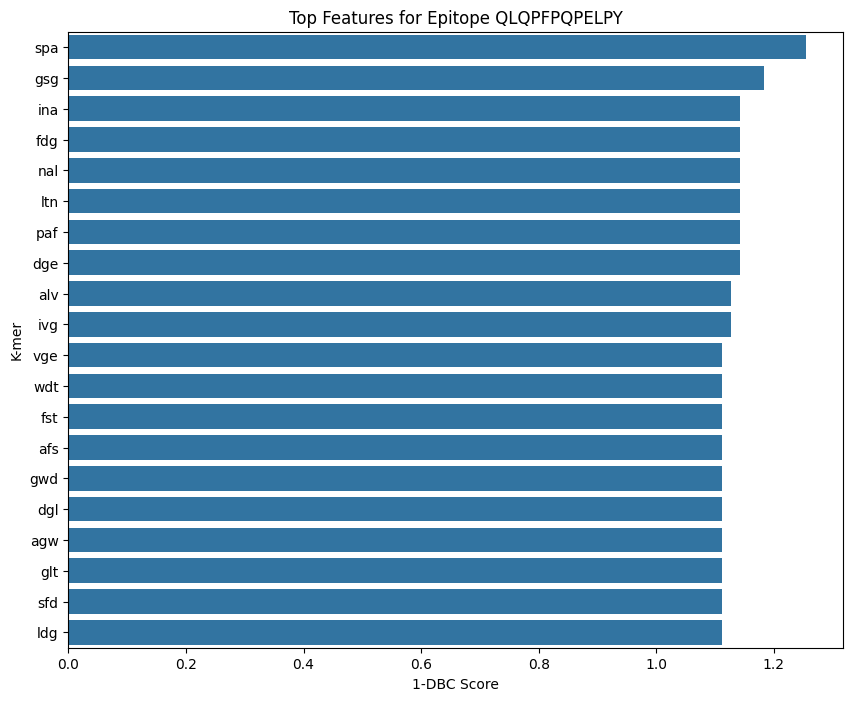

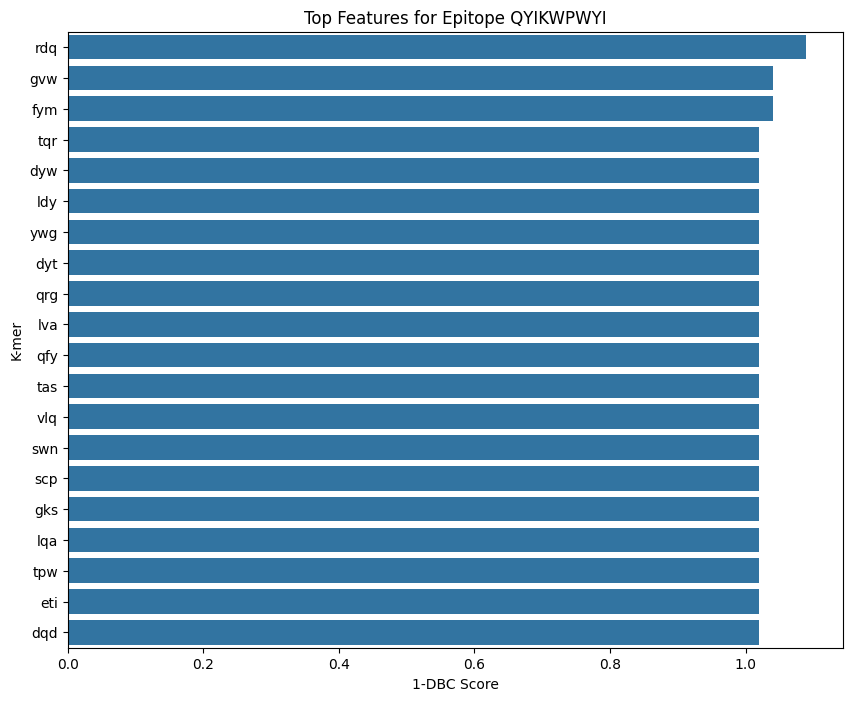

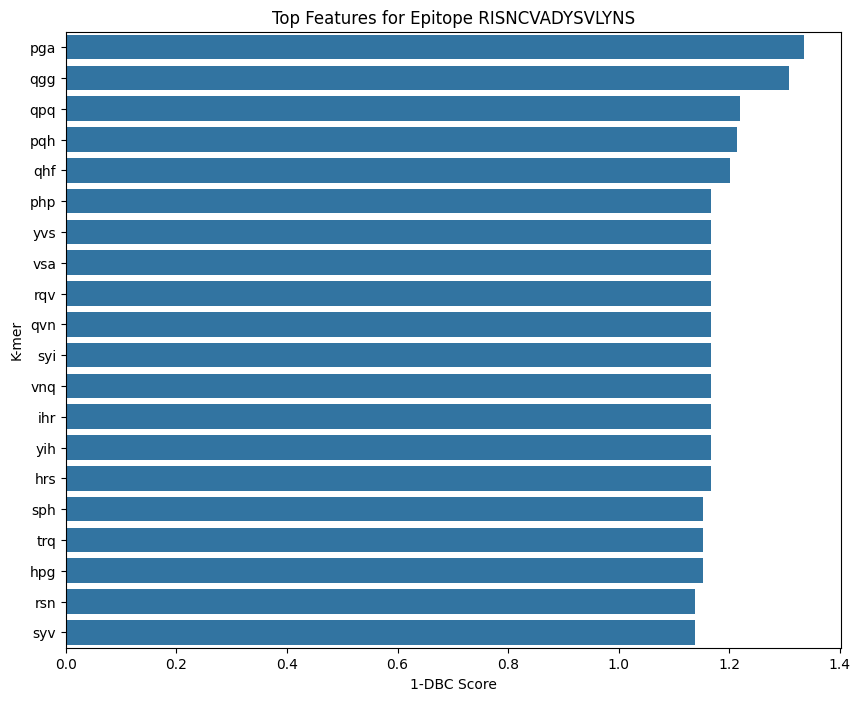

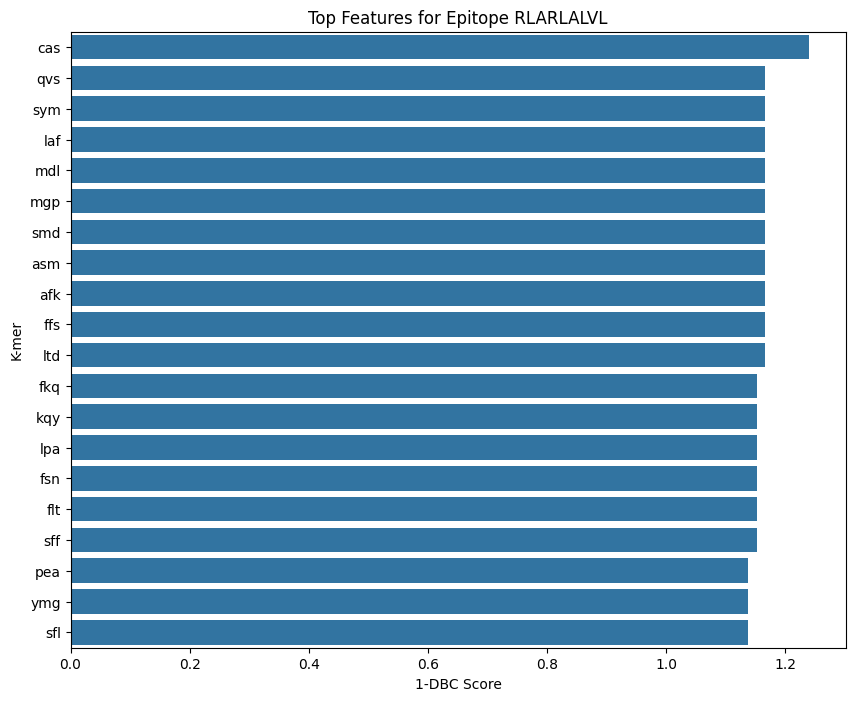

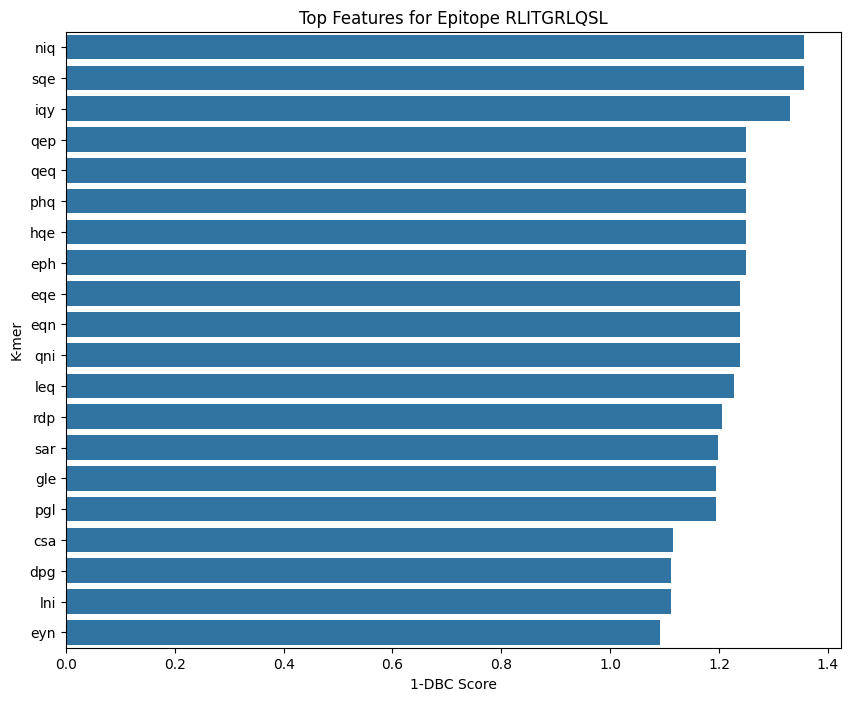

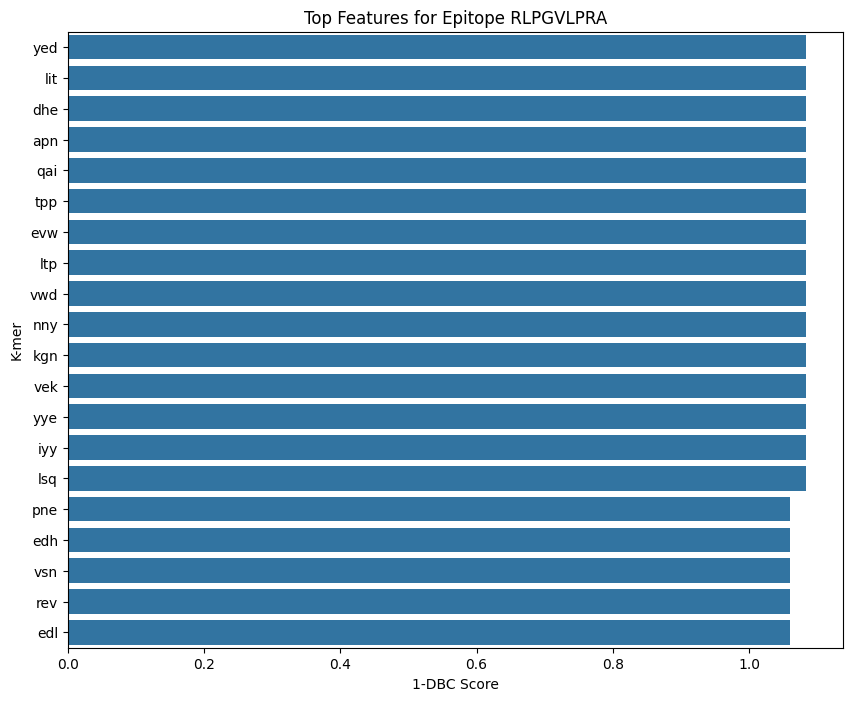

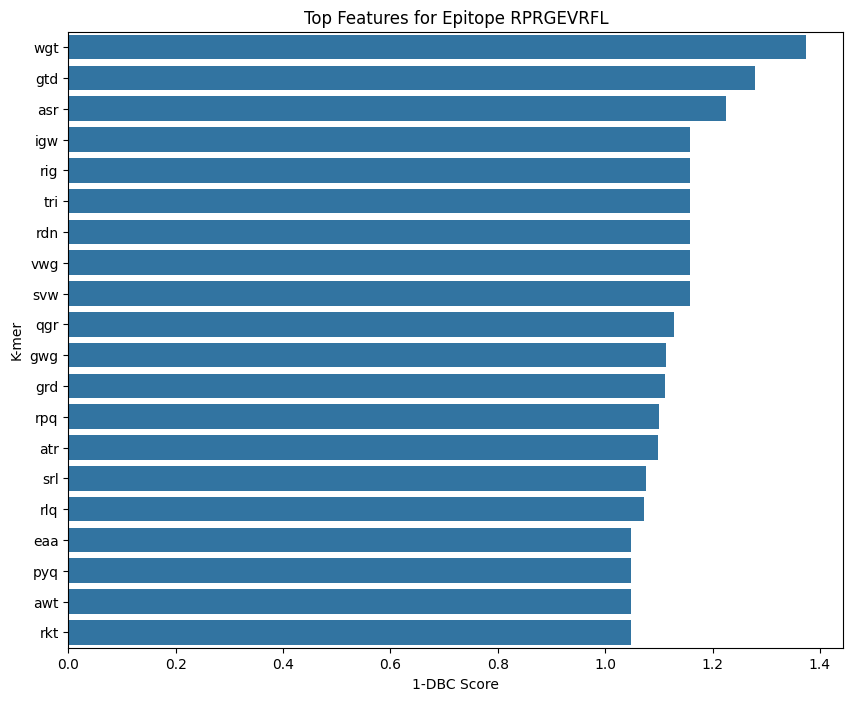

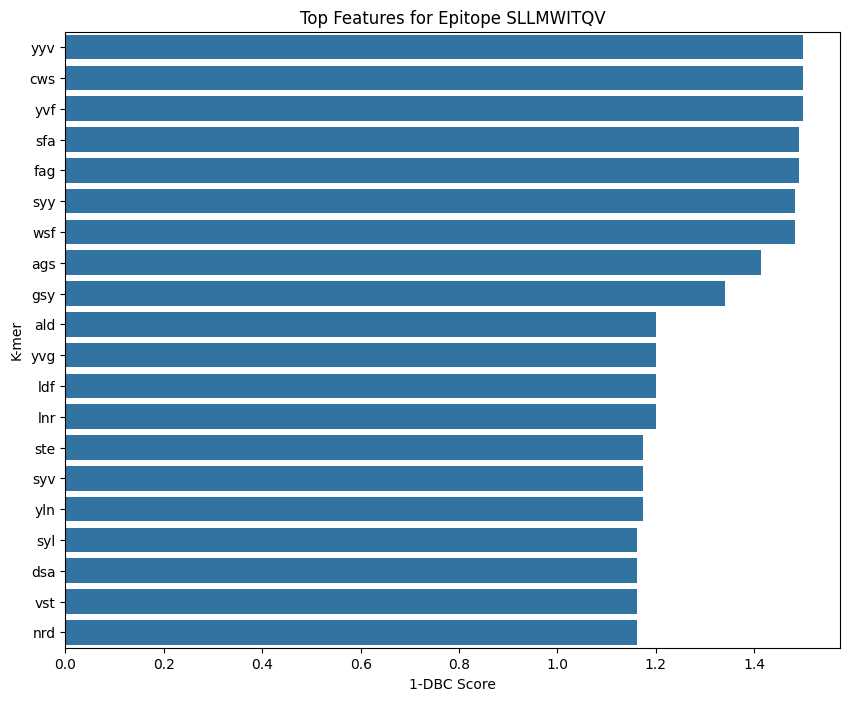

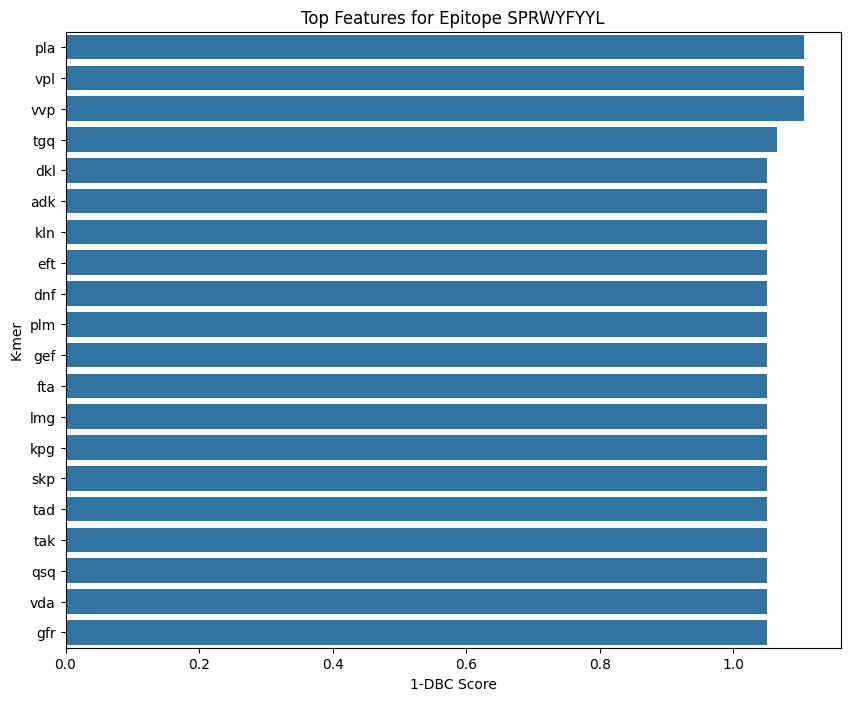

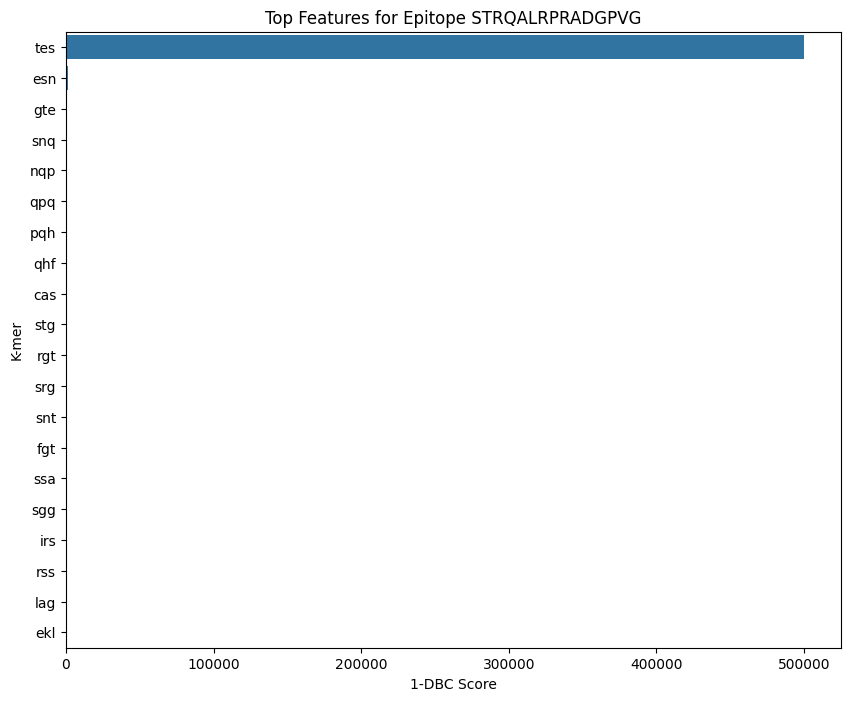

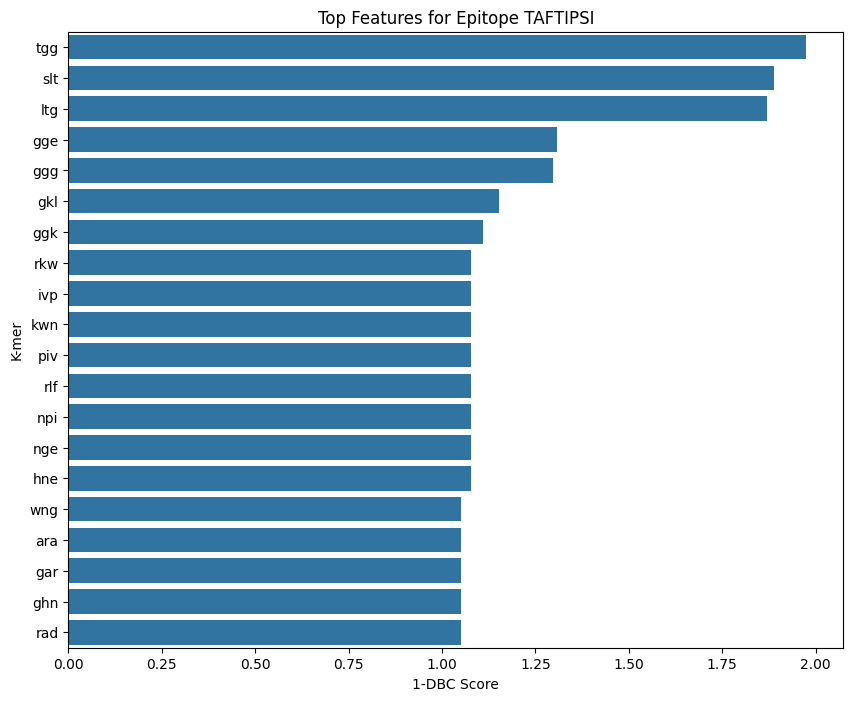

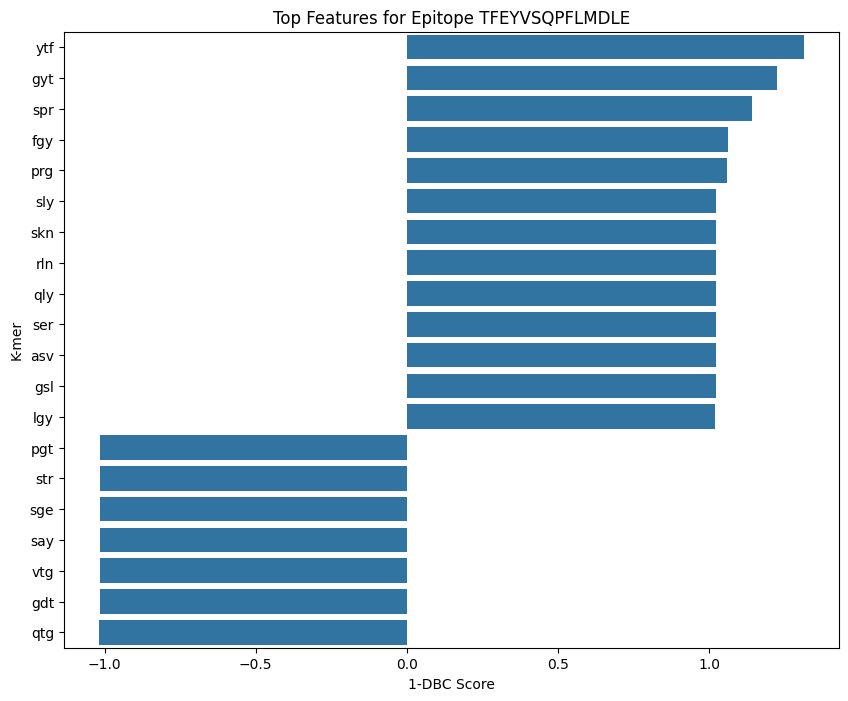

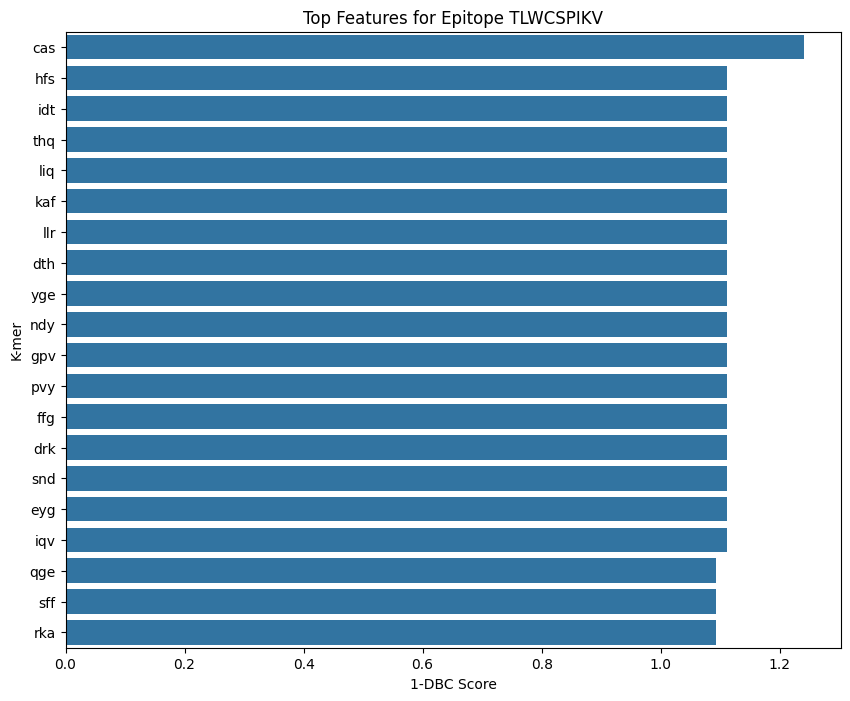

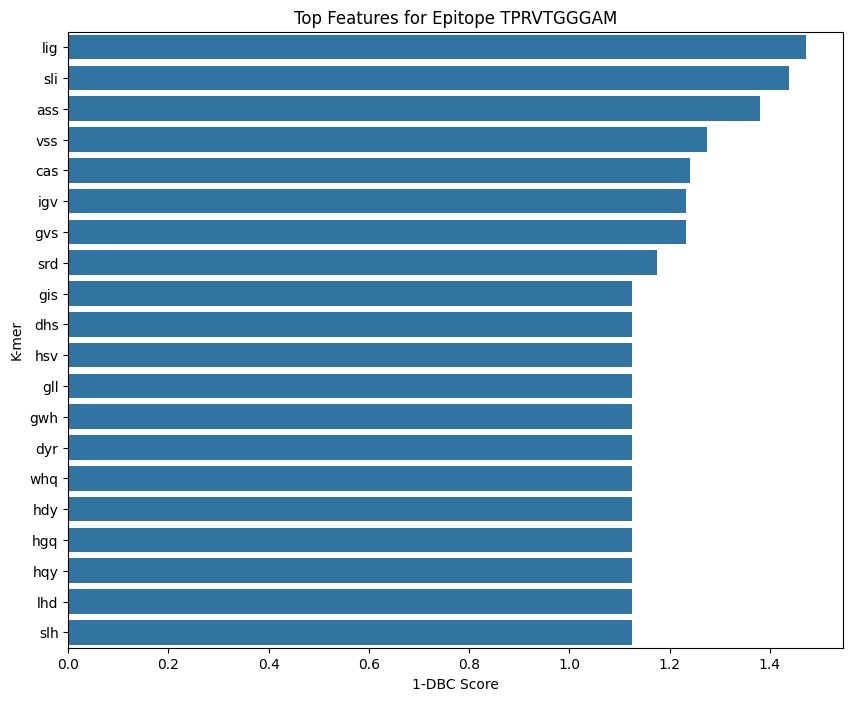

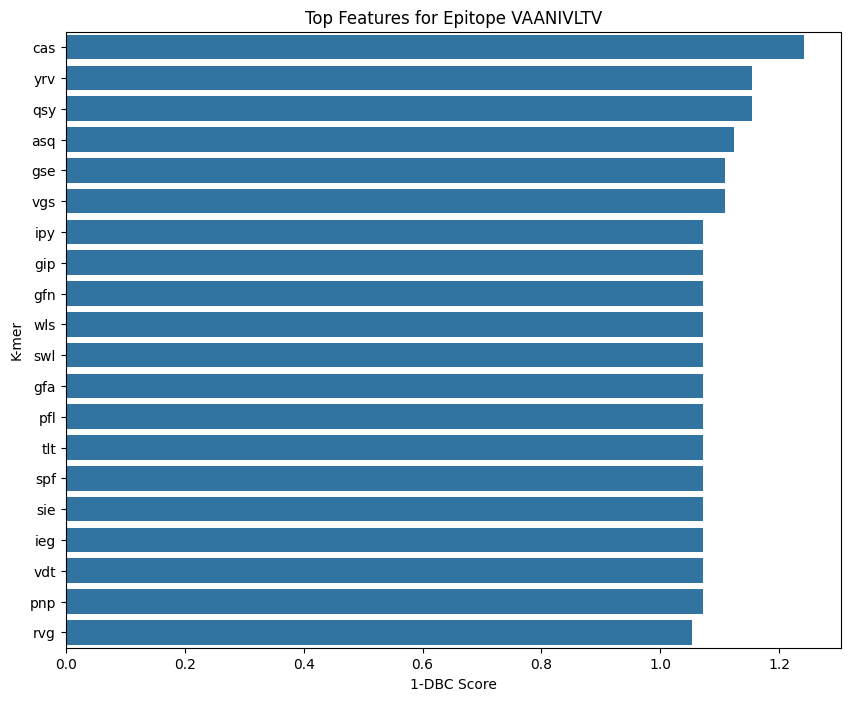

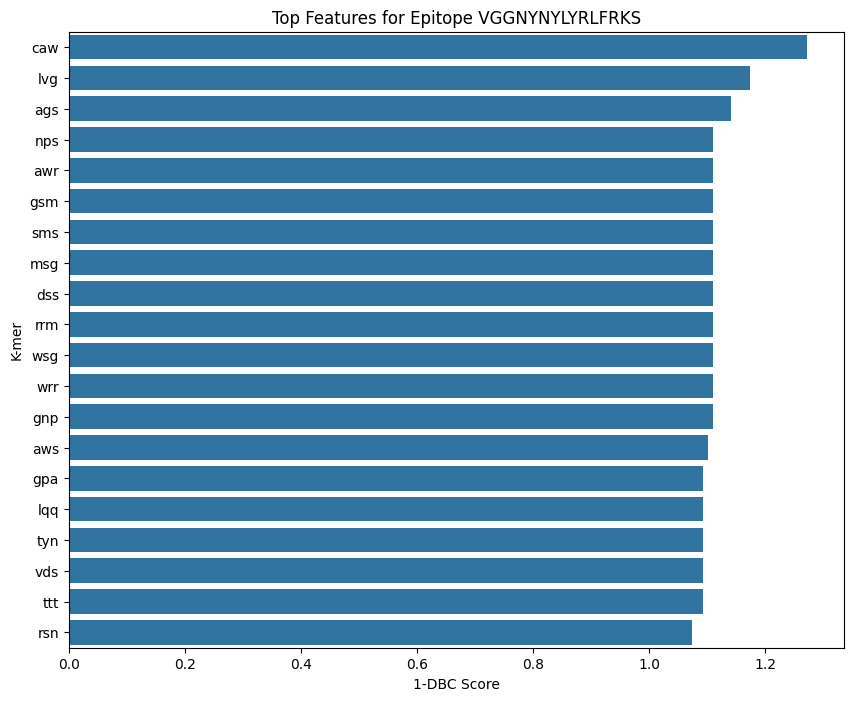

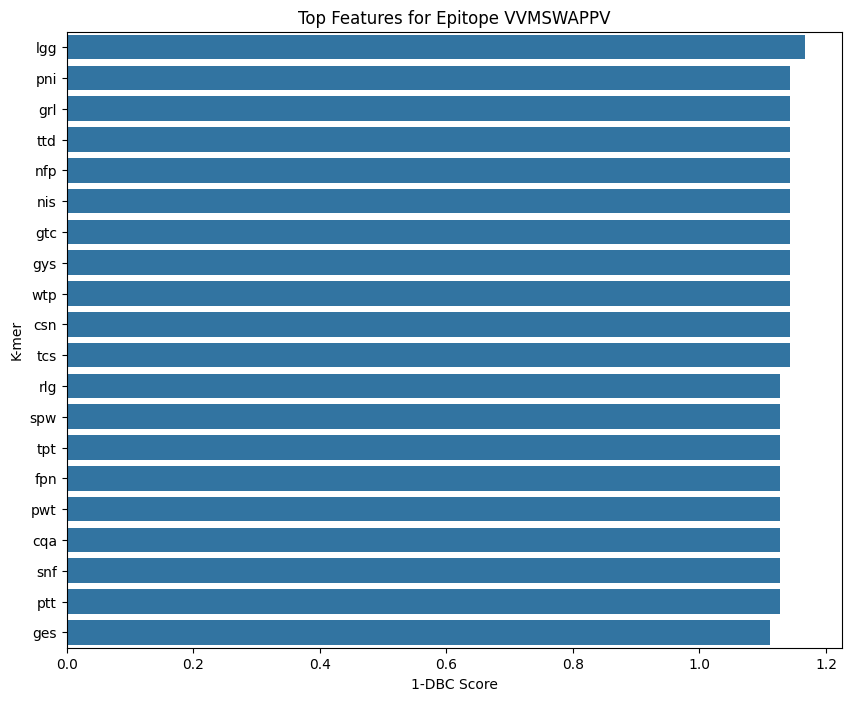

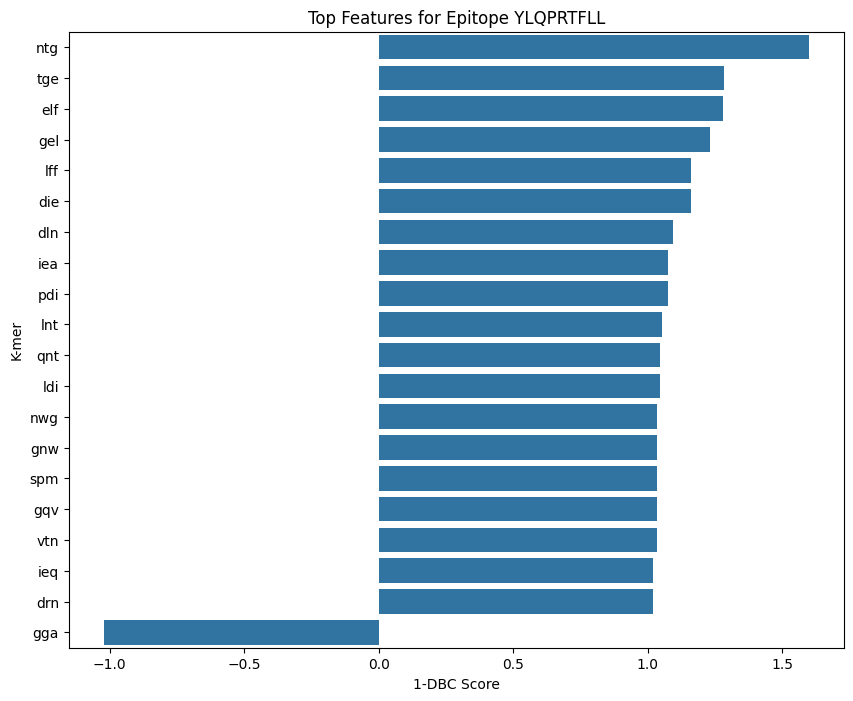

In [12]:
from filtering_functions import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import label_binarize
#from scipy import interp
from sklearn.base import clone
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cross_decomposition import CCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
import warnings
from sklearn.metrics import classification_report, confusion_matrix

# Function to generate k-mers from a single sequence
def generate_kmers(sequence, k):
    return [sequence[i:i+k] for i in range(len(sequence)-k+1)]

# def create_features_matrix(df, include_alpha=True, include_beta=True, alpha_col='cdr3.alpha', beta_col='cdr3.beta', label_col='antigen.epitope', k=3):
#     # Filter rows where label is missing
#     filtered_df = df.dropna(subset=[label_col])
    
#     # Initialize documents for CountVectorizer and k-mer count dictionary
#     kmer_docs = []
#     kmer_count_dict = {}
    
#     # Process sequences based on inclusion flags
#     for _, row in filtered_df.iterrows():
#         kmers = []
#         if include_alpha and pd.notna(row[alpha_col]):
#             alpha_seq = row[alpha_col]
#             kmers += generate_kmers(alpha_seq, k)
#         if include_beta and pd.notna(row[beta_col]):
#             beta_seq = row[beta_col]
#             kmers += generate_kmers(beta_seq, k)
        
#         # Concatenate k-mers into a single string for vectorization
#         kmer_docs.append(' '.join(kmers))
        
#         # Count occurrences of each k-mer
#         for kmer in kmers:
#             kmer_count_dict[kmer] = kmer_count_dict.get(kmer, 0) + 1
    
#     # Vectorize k-mer documents into a feature matrix
#     vectorizer = CountVectorizer(analyzer='word', token_pattern=r"(?u)\b\w+\b")
#     X = vectorizer.fit_transform(kmer_docs).toarray()
    
#     # Create a mapping from epitope names to integers
#     unique_epitopes = filtered_df[label_col].unique()
#     epitope_to_int = {epitope: i for i, epitope in enumerate(unique_epitopes)}
    
#     # Transform labels into integers based on the mapping
#     y = filtered_df[label_col].map(epitope_to_int).values
    
#     # Get unique k-mer names used in the matrix
#     feature_names = vectorizer.get_feature_names_out()
#     epitope_names = list(epitope_to_int.keys())
#     # Return the adjusted outputs
#     return X, y, feature_names, kmer_count_dict, epitope_names, epitope_to_int

def create_features_matrix(df, include_alpha=True, include_beta=True, alpha_col='cdr3.alpha', beta_col='cdr3.beta', label_col='antigen.epitope', k=3):
    # Filter rows where label is missing
    filtered_df = df.dropna(subset=[label_col])
    
    # Initialize documents for CountVectorizer and k-mer count dictionary
    kmer_docs = []
    kmer_count_dict = {}
    
    # Process sequences based on inclusion flags
    for _, row in filtered_df.iterrows():
        kmers = []
        if include_alpha and pd.notna(row[alpha_col]):
            alpha_seq = row[alpha_col]
            kmers += generate_kmers(alpha_seq, k)
        if include_beta and pd.notna(row[beta_col]):
            beta_seq = row[beta_col]
            kmers += generate_kmers(beta_seq, k)
        
        # Concatenate k-mers into a single string for vectorization
        kmer_docs.append(' '.join(kmers))
        
        # Count occurrences of each k-mer
        for kmer in kmers:
            kmer_count_dict[kmer] = kmer_count_dict.get(kmer, 0) + 1
    
    # Vectorize k-mer documents into a feature matrix
    vectorizer = CountVectorizer(analyzer='word', token_pattern=r"(?u)\b\w+\b")
    X = vectorizer.fit_transform(kmer_docs).toarray()
    
    # Use epitope names directly as labels
    y = filtered_df[label_col].values
    
    # Get unique k-mer names used in the matrix
    feature_names = vectorizer.get_feature_names_out()
    epitope_names = filtered_df[label_col].unique()
    return X, y, feature_names, kmer_count_dict, epitope_names


def plot_feature_importance(classifier, feature_names, top_n=20):
    # Get feature importances from the classifier
    importances = classifier.feature_importances_
    
    # Create a list of tuples (feature_name, importance)
    feature_importance = list(zip(feature_names, importances))
    
    # Sort the feature importances by most important first
    feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
    
    # Taking the top n features
    top_features = feature_importance[:top_n]
    features, scores = zip(*top_features)
    
    # Plotting
    y_pos = np.arange(len(features))
    plt.barh(y_pos, scores, align='center', alpha=0.5)
    plt.yticks(y_pos, features)
    plt.xlabel('Importance')
    plt.title('Top {} Feature Importances'.format(top_n))
    plt.gca().invert_yaxis()  # Invert the Y-axis to show the highest value at the top
    plt.show()



def calculate_class_stats(X, y, feature_names):
    """ Calculate statistics for each feature across all classes for one-vs-all. """
    unique_classes = np.unique(y)
    stats = {}
    for cls in unique_classes:
        class_index = y == cls
        non_class_index = ~class_index
        stats[cls] = {
            'mean': np.mean(X[class_index], axis=0),
            'var': np.var(X[class_index], axis=0) + 1e-6,  # Avoid division by zero
            'mean_non_class': np.mean(X[non_class_index], axis=0),
            'var_non_class': np.var(X[non_class_index], axis=0) + 1e-6
        }
    return stats

def compute_1_DBC_scores(stats):
    """ Compute 1-DBC scores for each feature across all classes. """
    scores = {}
    for cls, data in stats.items():
        score = (data['mean'] - data['mean_non_class']) / (data['var'] + data['var_non_class'])
        scores[cls] = score
    return scores

def select_features(X, feature_names, scores, top_k=50):
    """ Select top features based on 1-DBC scores for all classes and return feature details. """
    all_top_indices = set()
    top_features = {}
    for cls, cls_scores in scores.items():
        top_indices = np.argsort(-np.abs(cls_scores))[:top_k]
        all_top_indices.update(top_indices)
        # Save the top features for this class
        top_features[cls] = {
            'indices': top_indices,
            'names': [feature_names[i] for i in top_indices],
            'scores': cls_scores[top_indices]
        }
    # Filter X for selected indices
    X_selected = X[:, list(all_top_indices)]
    return X_selected, top_features

# def plot_top_features(top_features, class_labels):
#     """ Plot the top features for each class. """
#     for cls in class_labels:
#         features = top_features[cls]
#         # Create a DataFrame for easier plotting
#         df = pd.DataFrame({
#             'Feature': features['names'],
#             'Score': features['scores']
#         })
#         df.sort_values(by='Score', ascending=False, inplace=True)
        
#         # Plotting
#         plt.figure(figsize=(10, 8))
#         sns.barplot(x='Score', y='Feature', data=df.head(20))  # Show top 20 features
#         plt.title(f'Top Features for Class {cls}')
#         plt.xlabel('1-DBC Score')
#         plt.ylabel('K-mer')
#         plt.show()
def plot_top_features(top_features, epitope_names):
    """ Plot the top features for each class. """
    for epitope in epitope_names:
        features = top_features[epitope]
        # Create a DataFrame for easier plotting
        df = pd.DataFrame({
            'Feature': features['names'],
            'Score': features['scores']
        })
        df.sort_values(by='Score', ascending=False, inplace=True)
        
        # Plotting
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Score', y='Feature', data=df.head(20))  # Show top 20 features
        plt.title(f'Top Features for Epitope {epitope}')
        plt.xlabel('1-DBC Score')
        plt.ylabel('K-mer')
        plt.show()



def find_unique_kmers(top_features, threshold=1.5):
    """
    Identify unique k-mers for each class based on 1-DBC scores.
    
    Args:
    top_features (dict): A dictionary with class indices as keys and another dictionary
                         containing indices, names, and scores of top k-mers as values.
    threshold (float): A threshold for determining uniqueness. A k-mer is considered unique
                       if its score is greater than this threshold and significantly higher
                       than its score in other classes.

    Returns:
    unique_kmers_per_class (dict): A dictionary with class indices as keys and lists of unique
                                   k-mer names as values.
    """
    unique_kmers_per_class = {cls: [] for cls in top_features.keys()}
    all_kmers_scores = {name: [] for cls in top_features for name in top_features[cls]['names']}
    
    # Collect all scores for each k-mer across classes
    for cls, features in top_features.items():
        for name, score in zip(features['names'], features['scores']):
            all_kmers_scores[name].append((cls, score))
    
    # Determine uniqueness by checking the score differences
    for kmer, scores in all_kmers_scores.items():
        if len(scores) == 1:  # Only appears in one class
            cls, score = scores[0]
            if score > threshold:
                unique_kmers_per_class[cls].append(kmer)
        else:
            # Sort scores and check if the highest is significantly larger than the second highest
            scores_sorted = sorted(scores, key=lambda x: x[1], reverse=True)
            if scores_sorted[0][1] > threshold and scores_sorted[0][1] > scores_sorted[1][1] * 2:
                unique_kmers_per_class[scores_sorted[0][0]].append(kmer)
    
    return unique_kmers_per_class

""" example usage"""

# X, y, feature_names, kmer_count_dict, epitope_names, epitope_to_int = create_features_matrix(df3, include_alpha=False, include_beta=True, alpha_col='cdr3.alpha', beta_col='cdr3.beta', label_col='antigen.epitope', k=3)
X_kmer , y_kmer, feature_names, kmer_count_dict, epitope_names = create_features_matrix(df3, include_alpha=False, include_beta=True, alpha_col='cdr3.alpha', beta_col='cdr3.beta', label_col='antigen.epitope', k=3)
print(y_kmer)


class_stats = calculate_class_stats(X_kmer, y_kmer, feature_names)
scores = compute_1_DBC_scores(class_stats)
X_selected, top_features = select_features(X_kmer, feature_names, scores, top_k=50)
unique_kmers = find_unique_kmers(top_features)
print(unique_kmers)

plot_top_features(top_features, np.unique(y_kmer))
# """
# """auc_result, acc, precision, recall, class_reports, conf_matrices,clf = predict_auc(X, y, rf_classifier, 2, epitope_names, True)"""
# """plot_feature_importance(clf, feature_names)"""


We have seen in previous attempts, using the distance matrix that epitopes with few binding tcrs do not get represented well in the distances based approaches. 

In [2]:
def filter_by_length_range(df, column_name):
    """
    Asks the user for length bounds and filters the DataFrame to include rows where the length of
    the specified column's sequence falls within the provided bounds.

    Parameters:
    df (DataFrame): The data frame to filter.
    column_name (str): The name of the sequence column to check (e.g., 'cdr3.alpha').

    Returns:
    DataFrame: A DataFrame filtered by the specified length range.
    """
    # Ask the user for length bounds
    lower_bound = int(input(f"Enter lower bound for {column_name} length: "))
    upper_bound = int(input(f"Enter upper bound for {column_name} length: "))
    
    # Calculate the sequence lengths
    df[column_name + '.length'] = df[column_name].apply(len)
    
    # Filter based on the length range
    return df[(df[column_name + '.length'] >= lower_bound) & (df[column_name + '.length'] <= upper_bound)]

def filter_by_species(df):
    """
    Asks the user for species to filter by and filters the DataFrame to include rows where the
    species column matches any of the species provided.

    Parameters:
    df (DataFrame): The data frame to filter.

    Returns:
    DataFrame: A DataFrame filtered by the specified species.
    """
    # Ask the user for species to filter by
    input_species = input("Enter the species to filter by (separated by commas): ")
    species_to_filter = [species.strip() for species in input_species.split(',')]
    
    return df[df['species'].isin(species_to_filter)]

def filter_by_epitope_frequency(dataframe, column_name, threshold):
    """
    Filters the provided DataFrame based on the frequency of appearances of values in a specified column.
    
    Args:
    dataframe (pd.DataFrame): The DataFrame to filter.
    column_name (str): The name of the column to filter by frequency.
    threshold (int): The minimum number of appearances for a value to be included in the filtered DataFrame.
    
    Returns:
    pd.DataFrame: A DataFrame filtered based on the frequency threshold.
    int: The number of unique values meeting the threshold.
    """
    # Count how many times each value appears
    value_counts = dataframe[column_name].value_counts()
    
    # Get the values that meet or exceed the threshold
    frequent_values = value_counts[value_counts > threshold].index
    
    # Filter the DataFrame to include only rows where the value appears at least 'threshold' times
    filtered_dataframe = dataframe[dataframe[column_name].isin(frequent_values)]
    
    # Count of unique values that meet the threshold
    unique_value_count = len(frequent_values)
    
    return filtered_dataframe, unique_value_count
    


def filter_by_minimum_score(df, column='vdjdb.score'):
    """
    Filters the DataFrame based on a minimum score inputted by the user for a specified column.
    
    Parameters:
    df (DataFrame): The data frame to filter.
    column (str): The name of the column to apply the filter on. Defaults to 'vdjdb.score'.
    
    Returns:
    DataFrame: A DataFrame filtered based on the user-specified minimum score.
    """
    # Prompting user for minimum score
    min_score = input(f"Enter the minimum score (inclusive) for {column}: ")
    
    # Validating user input
    try:
        min_score = int(min_score)
        if min_score < 0 or min_score > 3:
            print("Score out of range. Please enter a value between 0 and 3.")
            return df
    except ValueError:
        print("Invalid input. Please enter an integer value.")
        return df
    
    # Filtering the DataFrame
    filtered_df = df[df[column] >= min_score]
    
    return filtered_df

def filter_by_mhc_class(df, column='mhc.class'):
    """
    Filters the DataFrame based on a user-specified MHC class ('MHCI' or 'MHCII').

    Parameters:
    df (DataFrame): The data frame to filter.
    column (str): The name of the column to apply the filter on. Defaults to 'mhc.class'.

    Returns:
    DataFrame: A DataFrame filtered based on the user-specified MHC class.
    """
    # Prompting user for MHC class
    mhc_class = input(f"Enter the MHC class to keep ('MHCI' or 'MHCII'): ").strip()

    # Validating user input
    if mhc_class not in ['MHCI', 'MHCII']:
        print("Invalid input. Please enter 'MHCI' or 'MHCII'.")
        return df
    
    # Filtering the DataFrame
    filtered_df = df[df[column] == mhc_class]
    
    return filtered_df




# Assuming df is your DataFrame
df = df_cleaned
# Apply length range filters
df_filtered_alpha = filter_by_length_range(df, 'cdr3.alpha')
df_filtered_beta = filter_by_length_range(df, 'cdr3.beta')
df_filtered_epitope = filter_by_length_range(df, 'antigen.epitope')
df_filtered_min_score = filter_by_minimum_score(df)
# Intersect the filtered DataFrames to get only rows that meet all criteria
df_length_filtered = df_filtered_alpha.merge(df_filtered_beta).merge(df_filtered_epitope)

# Further filter by species
df_final_filtered = filter_by_species(df_length_filtered)

# df_final_filtered is now your preprocessed DataFrame



Enter lower bound for cdr3.alpha length: 12
Enter upper bound for cdr3.alpha length: 14


/var/folders/dg/1nsyrpm96v149hfhy4g6qc0h0000gn/T/ipykernel_1741/163780384.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name + '.length'] = df[column_name].apply(len)


Enter lower bound for cdr3.beta length: 12
Enter upper bound for cdr3.beta length: 14


/var/folders/dg/1nsyrpm96v149hfhy4g6qc0h0000gn/T/ipykernel_1741/163780384.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name + '.length'] = df[column_name].apply(len)


Enter lower bound for antigen.epitope length: 0
Enter upper bound for antigen.epitope length: 100


/var/folders/dg/1nsyrpm96v149hfhy4g6qc0h0000gn/T/ipykernel_1741/163780384.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name + '.length'] = df[column_name].apply(len)


Enter the minimum score (inclusive) for vdjdb.score: 1
Enter the species to filter by (separated by commas): HomoSapiens


In [ ]:
# Filtered dataset

In [7]:
df_final_filtered

# df_final_filtered.drop(['d.beta'], axis=1, inplace=True)

df_final_filtered.drop(['j.beta'], axis=1, inplace=True)

print(df_final_filtered.isnull().sum())

cdr3.alpha                0
v.alpha                   0
cdr3.beta                 0
v.beta                    0
species                   0
mhc.a                     0
mhc.b                     0
antigen.gene              8
antigen.epitope           0
vdjdb.score               0
mhc.class                 0
cdr3.alpha.length         0
cdr3.beta.length          0
antigen.epitope.length    0
dtype: int64


/var/folders/dg/1nsyrpm96v149hfhy4g6qc0h0000gn/T/ipykernel_58657/1803294583.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_filtered.drop(['j.beta'], axis=1, inplace=True)


# CDR3 seq TCRdist

In [5]:
from tcrsampler.setup_db import install_all_next_gen
install_all_next_gen(dry_run = False)
from tcrdist.rep_funcs import _pws, _pw  
from tcrdist.repertoire import TCRrep

RUNNING: curl -o /Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/tcrsampler/db/wiraninha_sampler.zip https://www.dropbox.com/s/ily0td3tn1uc7bi/wiraninha_sampler.zip?dl=1 -L


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    66    0    66    0     0    207      0 --:--:-- --:--:-- --:--:--   207
100   320  100   320    0     0    407      0 --:--:-- --:--:-- --:--:--     0
100 6882k  100 6882k    0     0  2412k      0  0:00:02  0:00:02 --:--:-- 6554k
replace /Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/tcrsampler/db/wirasinha_mouse_alpha_g8a.tsv.sampler.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


Archive:  /Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/tcrsampler/db/wiraninha_sampler.zip
RUNNING: curl -o /Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/tcrsampler/db/ravens_samplers.zip https://www.dropbox.com/s/bahxa6x86drq0n5/ravens_samplers.zip?dl=1 -L


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    64    0    64    0     0    129      0 --:--:-- --:--:-- --:--:--   130
100   320  100   320    0     0    250      0  0:00:01  0:00:01 --:--:--     0
100  313k  100  313k    0     0   181k      0  0:00:01  0:00:01 --:--:--  181k
replace /Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/tcrsampler/db/ravens_human_gamma_t.sampler.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  /Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/tcrsampler/db/ravens_samplers.zip
RUNNING: curl -o /Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/tcrsampler/db/olga_sampler.zip https://www.dropbox.com/s/qlsxvst8bn04l0n/olga_sampler.zip?dl=1 -L


100    61    0    61    0     0    109      0 --:--:-- --:--:-- --:--:--   108
100   320  100   320    0     0    285      0  0:00:01  0:00:01 --:--:--     0
100 23.5M  100 23.5M    0     0  5612k      0  0:00:04  0:00:04 --:--:-- 9529k
replace /Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/tcrsampler/db/olga_human_beta_t.sampler.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  /Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/tcrsampler/db/olga_sampler.zip
RUNNING: curl -o /Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/tcrsampler/db/ruggiero_mouse_sampler.zip https://www.dropbox.com/s/yz8v1c1gf2eyzxk/ruggiero_mouse_sampler.zip?dl=1 -L


100    71    0    71    0     0    220      0 --:--:-- --:--:-- --:--:--   220
100   320  100   320    0     0    386      0 --:--:-- --:--:-- --:--:--     0
100  210k  100  210k    0     0   158k      0  0:00:01  0:00:01 --:--:--  158k
replace /Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/tcrsampler/db/ruggiero_mouse_alpha_t.tsv.sampler.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  /Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/tcrsampler/db/ruggiero_mouse_sampler.zip
RUNNING: curl -o /Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/tcrsampler/db/ruggiero_human_sampler.zip https://www.dropbox.com/s/jda6qtemk65zlfk/ruggiero_human_sampler.zip?dl=1 -L


100    71    0    71    0     0    226      0 --:--:-- --:--:-- --:--:--   226
100   320  100   320    0     0    109      0  0:00:02  0:00:02 --:--:--   199
100  599k  100  599k    0     0   173k      0  0:00:03  0:00:03 --:--:-- 6867k
replace /Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/tcrsampler/db/ruggiero_human_alpha_t.tsv.sampler.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  /Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/tcrsampler/db/ruggiero_human_sampler.zip
RUNNING: curl -o /Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/tcrsampler/db/emerson_human_beta_t_cmvneg.tsv.sampler.tsv.zip https://www.dropbox.com/s/04mxrzw7f5wkg1x/emerson_human_beta_t_cmvneg.tsv.sampler.tsv.zip?dl=1 -L


100    92    0    92    0     0    193      0 --:--:-- --:--:-- --:--:--   193
100   320  100   320    0     0    293      0  0:00:01  0:00:01 --:--:--     0
100 11.3M  100 11.3M    0     0  4318k      0  0:00:02  0:00:02 --:--:-- 12.7M
replace /Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/tcrsampler/db/emerson_human_beta_t_cmvneg.tsv.sampler.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  /Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/tcrsampler/db/emerson_human_beta_t_cmvneg.tsv.sampler.tsv.zip
RUNNING: curl -o /Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/tcrsampler/db/britanova_human_beta_t_cb.tsv.sampler.tsv.zip https://www.dropbox.com/s/87n5v2by80xhy1q/britanova_human_beta_t_cb.tsv.sampler.tsv.zip?dl=1 -L


100    90    0    90    0     0    325      0 --:--:-- --:--:-- --:--:--   326
100   320  100   320    0     0    366      0 --:--:-- --:--:-- --:--:--   366
100 28.3M  100 28.3M    0     0  6234k      0  0:00:04  0:00:04 --:--:-- 8181k
replace /Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/tcrsampler/db/britanova_human_beta_t_cb.tsv.sampler.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


Archive:  /Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/tcrsampler/db/britanova_human_beta_t_cb.tsv.sampler.tsv.zip


/Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [6]:
df_final_filtered.rename(columns={'cdr3.alpha': 'cdr3_a_aa', 'cdr3.beta': 'cdr3_b_aa', 'v.alpha':'v_a_gene','j.alpha': 'j_a_gene','v.beta': 'v_b_gene','j.beta': 'j_b_gene','antigen.epitope':'epitope'}, inplace=True)

print(np.shape(df_final_filtered))
def cdr3plot2(df_):
    # Assuming TCRrep is correctly set up to work with the provided dataframe
    tr_vdjdb = TCRrep(cell_df=df_, 
                      organism='human',
                      chains=['beta', 'alpha'],
                      deduplicate=False,
                      compute_distances=True )
    
    tcrdist_matrix = tr_vdjdb.pw_cdr3_b_aa
    return tcrdist_matrix

tcrdist_matrix =  cdr3plot2(df_final_filtered)
print(tcrdist_matrix)
print(np.shape(tcrdist_matrix))

/var/folders/dg/1nsyrpm96v149hfhy4g6qc0h0000gn/T/ipykernel_54338/2049687273.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_filtered.rename(columns={'cdr3.alpha': 'cdr3_a_aa', 'cdr3.beta': 'cdr3_b_aa', 'v.alpha':'v_a_gene','j.alpha': 'j_a_gene','v.beta': 'v_b_gene','j.beta': 'j_b_gene','antigen.epitope':'epitope'}, inplace=True)
/Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/tcrdist/repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
/Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/tcrdist/repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
/Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/tc

(8816, 13)
[[ 0 24 24 ... 24 31 32]
 [24  0  0 ... 20 27 23]
 [24  0  0 ... 20 27 23]
 ...
 [24 20 20 ...  0 23 20]
 [31 27 27 ... 23  0 24]
 [32 23 23 ... 20 24  0]]
(8816, 8816)


Below code accounts for large datasets ( >10000 ), but the tcrdist only provides sparse matrix for this number of datapoints. Dont know how to label with a sparse dataset. 

In [9]:
def cdr3plot2(df_):
    # Assuming TCRrep is correctly set up to work with the provided dataframe
    tr_vdjdb = TCRrep(cell_df=df_, 
                      organism='human',
                      chains=['beta', 'alpha'],
                      deduplicate=False)

    # Check if the size exceeds 10,000, to manage memory usage more efficiently
    if len(df_) > 10000:
        # Set the number of CPUs to use for parallel computation
        tr_vdjdb.cpus = 4  # Adjust this number based on your system's capabilities

        # Compute sparse rectangular distances for large datasets
        # The radius parameter can be adjusted based on your specific requirements
        tr_vdjdb.compute_sparse_rect_distances(radius=50, chunk_size=100)

        # Accessing the sparse matrix of distances stored in rw_beta
        tcrdist_matrix = tr_vdjdb.rw_beta
        
        from scipy.sparse import csr_matrix

        # Assuming `tcrdist_matrix` is your sparse matrix
        tcrdist_matrix_csr = csr_matrix(tcrdist_matrix)
    else:
        # For smaller datasets, proceed with the standard distance computation
        tr_vdjdb.compute_distances()
        tcrdist_matrix = tr_vdjdb.pw_cdr3_b_aa

    return tcrdist_matrix
tcrdist_matrix =  cdr3plot2(df_final_filtered)
print(tcrdist_matrix)
print(np.shape(tcrdist_matrix))


/Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/tcrdist/repertoire.py:201: UserWarning: 

When TCRrep.<clone_df> size 11078 > 10,000.
	TCRrep.compute_distances() may be called explicitly by a user
	with knowledge of system memory availability.
	However, it's HIGHLY unlikely that you want to compute such
	a large numpy array. INSTEAD, if you want all pairwise distance,
	you will likely want to set an appropriate number of cpus with TCRrep.cpus = x,
	and then generate a scipy.sparse csr matrix of distances with:
	TCRrep.compute_sparse_rect_distances(radius=50, chunk_size=100), leaving df and df2 arguments blank.
	When you do this the results will be stored as TCRrep.rw_beta instead of TCRrep.pw_beta.
	This function is highly useful for comparing a smaller number of sequences against a bulk set
	In such a case, you can specify df and df2 arguments to create a non-square matrix of distances.
	See https://tcrdist3.readthedocs.io/en/latest/sparsity.html?highlight=sparse for more in

  0%|          | 0/111 [00:00<?, ?it/s]

/Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/tomelder/opt/anaconda3/lib/python3.9/si

  0%|          | 0/111 [00:00<?, ?it/s]

/Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/tomelder/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/tomelder/opt/anaconda3/lib/python3.9/si

  (0, 0)	-1
  (1, 1)	-1
  (1, 1332)	42
  (1, 10800)	48
  (1, 10841)	48
  (2, 2)	-1
  (2, 4)	30
  (3, 3)	-1
  (3, 244)	48
  (3, 10956)	48
  (3, 10976)	36
  (3, 10987)	48
  (4, 2)	30
  (4, 4)	-1
  (4, 1397)	48
  (4, 9652)	48
  (4, 11034)	48
  (5, 5)	-1
  (5, 6)	36
  (6, 5)	36
  (6, 6)	-1
  (6, 7)	36
  (6, 710)	48
  (7, 6)	36
  (7, 7)	-1
  :	:
  (11067, 1057)	48
  (11067, 1058)	48
  (11067, 9678)	12
  (11067, 11067)	-1
  (11068, 11068)	-1
  (11069, 11069)	-1
  (11070, 284)	36
  (11070, 285)	36
  (11070, 10911)	48
  (11070, 11070)	-1
  (11071, 11071)	-1
  (11072, 11072)	-1
  (11073, 9452)	48
  (11073, 9710)	36
  (11073, 10105)	48
  (11073, 11073)	-1
  (11074, 11074)	-1
  (11075, 281)	30
  (11075, 11031)	48
  (11075, 11075)	-1
  (11076, 10760)	42
  (11076, 10761)	42
  (11076, 10820)	21
  (11076, 11076)	-1
  (11077, 11077)	-1
(11078, 11078)


### DBscan

In [7]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(metric='precomputed', eps=0.2, min_samples=2)  # Example: eps value here is hypothetical
clusters = dbscan.fit_predict(tcrdist_matrix)

# Adding cluster labels to your data (assuming you have a DataFrame 'df' with your TCR sequence data)
df_final_filtered['cluster'] = clusters

df_final_filtered

# Exclude outlier points and count unique clusters
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)

print(f"Number of DBscan clusters: {n_clusters}")

print(f"Number of Epitopes: {len(df_final_filtered['epitope'].unique())}")


Number of DBscan clusters: 31
Number of Epitopes: 71


/var/folders/dg/1nsyrpm96v149hfhy4g6qc0h0000gn/T/ipykernel_54338/947410217.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_filtered['cluster'] = clusters


### Random classifier for baseline

Random Clustering:

The model randomly assigns TCR sequences to a predetermined number of clusters, mirroring the number your actual clustering algorithm produces. This process simulates a scenario where clusters are formed without any underlying biological or data-driven rationale.
Calculating Purity and Consistency:

Purity: For each randomly formed cluster, the model calculates the proportion of the most common epitope in that cluster. The idea is to see, on average, how often random clustering accidentally groups sequences by epitope. High purity in random clustering indicates that the dataset's imbalance might significantly influence purity scores.
Consistency: This measures how often sequences that bind to the same epitope end up in the same cluster, based on the random assignments. It assesses if the random clusters align sequences by epitope as effectively as the actual method.
Simulation Over Multiple Iterations:

The process of random clustering and subsequent evaluation of purity and consistency is repeated multiple times (e.g., 50). This repetition helps smooth out variances due to the randomness, providing a more reliable average baseline for these metrics.

In [8]:
def random_clustering(df, n_clusters):
    """Assigns each row in the dataframe to a random cluster."""
    random_clusters = np.random.randint(0, n_clusters, len(df))
    df['random_cluster'] = random_clusters
    return df

def calculate_random_purity(df):
    purity_sum = 0
    for cluster in df['random_cluster'].unique():
        cluster_df = df[df['random_cluster'] == cluster]
        most_common_epitope = cluster_df['epitope'].value_counts().idxmax()
        purity_sum += cluster_df['epitope'].value_counts().max() / len(cluster_df)
    purity = purity_sum / len(df['random_cluster'].unique())
    return purity

def calculate_random_consistency(df, epitope_clusters):
    correct_assignments = 0
    for epitope, cluster in epitope_clusters.items():
        correct_assignments += len(df[(df['epitope'] == epitope) & (df['random_cluster'] == cluster)])
    consistency = correct_assignments / len(df)
    return consistency

def simulate_baseline(df, n_clusters, iterations=50):
    purity_scores = []
    consistency_scores = []
    def get_epitope_clusters(df):
        epitope_clusters = {}
        for epitope in df['epitope'].unique():
            epitope_df = df[df['epitope'] == epitope]
            most_common_cluster = epitope_df['cluster'].value_counts().idxmax()
            epitope_clusters[epitope] = most_common_cluster
        return epitope_clusters

    # Assuming df_final_filtered has 'cluster' column from DBSCAN and 'epitope' information
    epitope_clusters = get_epitope_clusters(df_final_filtered)

  # This should come from your actual clustering method

    for _ in range(iterations):
        df_random = random_clustering(df.copy(), n_clusters)
        purity = calculate_random_purity(df_random)
        consistency = calculate_random_consistency(df_random, epitope_clusters)
        
        purity_scores.append(purity)
        consistency_scores.append(consistency)
    
    return np.mean(purity_scores), np.mean(consistency_scores)

pur_base, consist_base = simulate_baseline(df_final_filtered, n_clusters)

### Evaluate DBscan clusters

In [9]:
def calculate_retention(df):
    # Retention is the fraction of TCR sequences assigned to any cluster
    assigned = df[df['cluster'] != -1]  # DBSCAN labels outliers as -1
    retention = len(assigned) / len(df)
    return retention

def calculate_purity(df):
    # Purity is defined for each cluster, then averaged across clusters
    purity_sum = 0
    for cluster in df['cluster'].unique():
        if cluster == -1:
            continue  # Skip noise points
        cluster_df = df[df['cluster'] == cluster]
        most_common_epitope = cluster_df['epitope'].value_counts().idxmax()
        purity_sum += cluster_df['epitope'].value_counts().max() / len(cluster_df)
    purity = purity_sum / (len(df['cluster'].unique()) - (1 if -1 in df['cluster'].unique() else 0))
    return purity

def calculate_consistency(df):
    # Consistency is calculated based on the assignment of TCR sequences to the "true" cluster for their epitope
    epitope_clusters = {}
    for epitope in df['epitope'].unique():
        epitope_df = df[df['epitope'] == epitope]
        most_common_cluster = epitope_df['cluster'].value_counts().idxmax()
        epitope_clusters[epitope] = most_common_cluster

    correct_assignments = 0
    for epitope, cluster in epitope_clusters.items():
        correct_assignments += len(df[(df['epitope'] == epitope) & (df['cluster'] == cluster)])

    consistency = correct_assignments / len(df[df['cluster'] != -1])
    return consistency



retention = calculate_retention(df_final_filtered)
purity = calculate_purity(df_final_filtered)
consistency = calculate_consistency(df_final_filtered)

print(f"Retention: {retention}")
print(f"Purity: {purity}")
print(f"Consistency: {consistency}")

print(f"Purity baseline: {pur_base}")
print(f"Consistency baseline: {consist_base}")

Retention: 0.9878629764065335
Purity: 0.9114656735829082
Consistency: 0.9799058445286485
Purity baseline: 0.969157044703137
Consistency baseline: 0.031801270417422874


## Supervised KNN

In [9]:
# from tcrdist.repertoire import TCRrep
# df_final_filtered.rename(columns={'cdr3.alpha': 'cdr3_a_aa', 'cdr3.beta': 'cdr3_b_aa', 'v.alpha':'v_a_gene','j.alpha': 'j_a_gene','v.beta': 'v_b_gene','j.beta': 'j_b_gene','antigen.epitope':'epitope'}, inplace=True)

# # Initialize TCRrep object
# tcr_rep = TCRrep(
#     cell_df = df_final_filtered,
#     organism = 'human', # Adjust based on your data, or dynamically set based on the 'species' column
#     chains = ['alpha', 'beta'],
#     compute_distances = True,
#     deduplicate = False 
# )

# from sklearn.neighbors import KNeighborsClassifier

# # Assume X (distance matrix) is derived from tcr_rep object
# X = pd.DataFrame(tcr_rep.pw_alpha + tcr_rep.pw_beta)
# # X = pd.DataFrame(tcr_rep.pw_beta)
# <k_cv> - number of cross-validation folds
k_cv = 5         
# <k_neighbours> -  number of neighbours for KNN
k_neighbours = 5  
# <organism> - tcrdist3 accepts 'mouse' or 'human'
organism = 'mouse'
# <chains> - tcrdist3 accepts ['alpha', 'beta'] or ['alpha'] or ['beta']
chains = ['alpha', 'beta'] 
# <cdr3> We can choose either 'cdr3' or 'all'. Choosing 'all' will 
# compute distances using CDR1,CDR2, and CDR2.5 as well as CDR3
cdrs = 'all' 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score



pw_beta_df1 = pd.read_csv('/Users/tomelder/Downloads/TCRdist distance matrices/pw_beta_df3.csv')
pw_alpha_df1 = pd.read_csv('/Users/tomelder/Downloads/TCRdist distance matrices/pw_alpha_df3.csv')
print(np.shape(pw_beta_df1))
print(np.shape(pw_alpha_df1))


X = pd.DataFrame(pw_alpha_df1 + pw_beta_df1)
print(np.shape(X))
Y = df3['antigen.epitope'] # Or any other column you wish to predict
print(np.shape(Y))

 

assert X.shape[0] == X.shape[1], f'X shape is not nXn: {X.shape[0]} == {X.shape[1]} ?'
assert X.shape[0] == Y.shape[0], f'X dimension does not equal Y dimension: {X.shape[0]} == {Y.shape[0]} ?'

# Reset indices to ensure they match if there have been any prior index modifications
X.reset_index(drop=True, inplace=True)
Y.reset_index(drop=True, inplace=True)

# Assert now that the indices have been reset
assert X.index.equals(Y.index), "X and Y indices are not equal after reset"

# dfs for storing metrics 
metrics_cv_df = pd.DataFrame(columns=['AUC', 'Accuracy', 'Recall', 'Precision'])
auc_cv_df = pd.DataFrame(columns=Y.unique())
recall_cv_df = pd.DataFrame(columns=Y.unique())
precision_cv_df = pd.DataFrame(columns=Y.unique())

# df for storing predictions (for confusion matrix)
preds_df = pd.DataFrame(columns=['y_true', 'y_pred'], index=Y.index)

# Get CV folds
kfolds = StratifiedKFold(n_splits=k_cv, shuffle=True, random_state=1)
kfolds.get_n_splits(X)

# perform CV
for train_ind, test_ind in kfolds.split(X, Y):
    # split data
    X_train, X_test = X.iloc[train_ind, train_ind], X.iloc[test_ind, train_ind]
    Y_train, Y_test = Y.iloc[train_ind], Y.iloc[test_ind]

    # train model
    model = KNeighborsClassifier(n_neighbors=k_neighbours, metric='precomputed', weights='distance') 
    model.fit(X_train, Y_train.ravel())

    # get predictions
    preds_labels = model.predict(X_test)
    preds_prob = model.predict_proba(X_test)

    # store in df
    preds_df.loc[Y_test.index, 'y_true'] = Y_test.loc[Y_test.index].values
    preds_df.loc[Y_test.index, 'y_pred'] = preds_labels

    ###--- calculate performance metrics

    # calculate & store average metrics
    Y_test_matrix = OneHotEncoder(categories=[model.classes_]).fit_transform(Y_test.values.reshape(-1, 1)).toarray()

    roc_auc_fold = roc_auc_score(Y_test_matrix, preds_prob, multi_class='ovr', average='macro')
    accuracy_fold = accuracy_score(Y_test, preds_labels)
    precision_fold = precision_score(Y_test, preds_labels, average='macro') # macro - simplest, unweighted mean between all classes
    recall_fold = recall_score(Y_test, preds_labels, average='macro') # macro - simplest, unweighted mean between all classes
    

    ## Append data to metrics DataFrames using pd.concat
    metrics_series = pd.Series({'AUC': roc_auc_fold, 'Accuracy': accuracy_fold, 'Recall': recall_fold, 'Precision': precision_fold})
    metrics_cv_df = pd.concat([metrics_cv_df, pd.DataFrame([metrics_series])], ignore_index=True)

    # Calculate & store AUC per epitope
    roc_auc_epitopes = roc_auc_score(Y_test_matrix, preds_prob, multi_class='ovr', average=None)
    auc_cv_df = pd.concat([auc_cv_df, pd.DataFrame([roc_auc_epitopes], columns=model.classes_)], ignore_index=True)

    # Calculate & store recall per epitope
    recall_epitopes = recall_score(Y_test, preds_labels, average=None, zero_division=0)
    recall_cv_df = pd.concat([recall_cv_df, pd.DataFrame([recall_epitopes], columns=model.classes_)], ignore_index=True)

    # Calculate & store precision per epitope
    precision_epitopes = precision_score(Y_test, preds_labels, average=None, zero_division=0)
    precision_cv_df = pd.concat([precision_cv_df, pd.DataFrame([precision_epitopes], columns=model.classes_)], ignore_index=True)


metrics_cv_df



(1244, 1244)
(1244, 1244)
(1244, 1244)
(1244,)


/var/folders/y8/_g3b_hys2dncxdddn9qg56100000gn/T/ipykernel_50035/3053601996.py:81: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  model.fit(X_train, Y_train.ravel())
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/y8/_g3b_hys2dncxdddn9qg56100000gn/T/ipykernel_50035/3053601996.py:104: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before t

,AUC,Accuracy,Recall,Precision
0,0.780589,0.598394,0.438619,0.448404
1,0.745145,0.554217,0.386242,0.333496
2,0.799870,0.618474,0.452532,0.466217
3,0.744857,0.542169,0.363394,0.327655
4,0.769874,0.600806,0.434166,0.448662


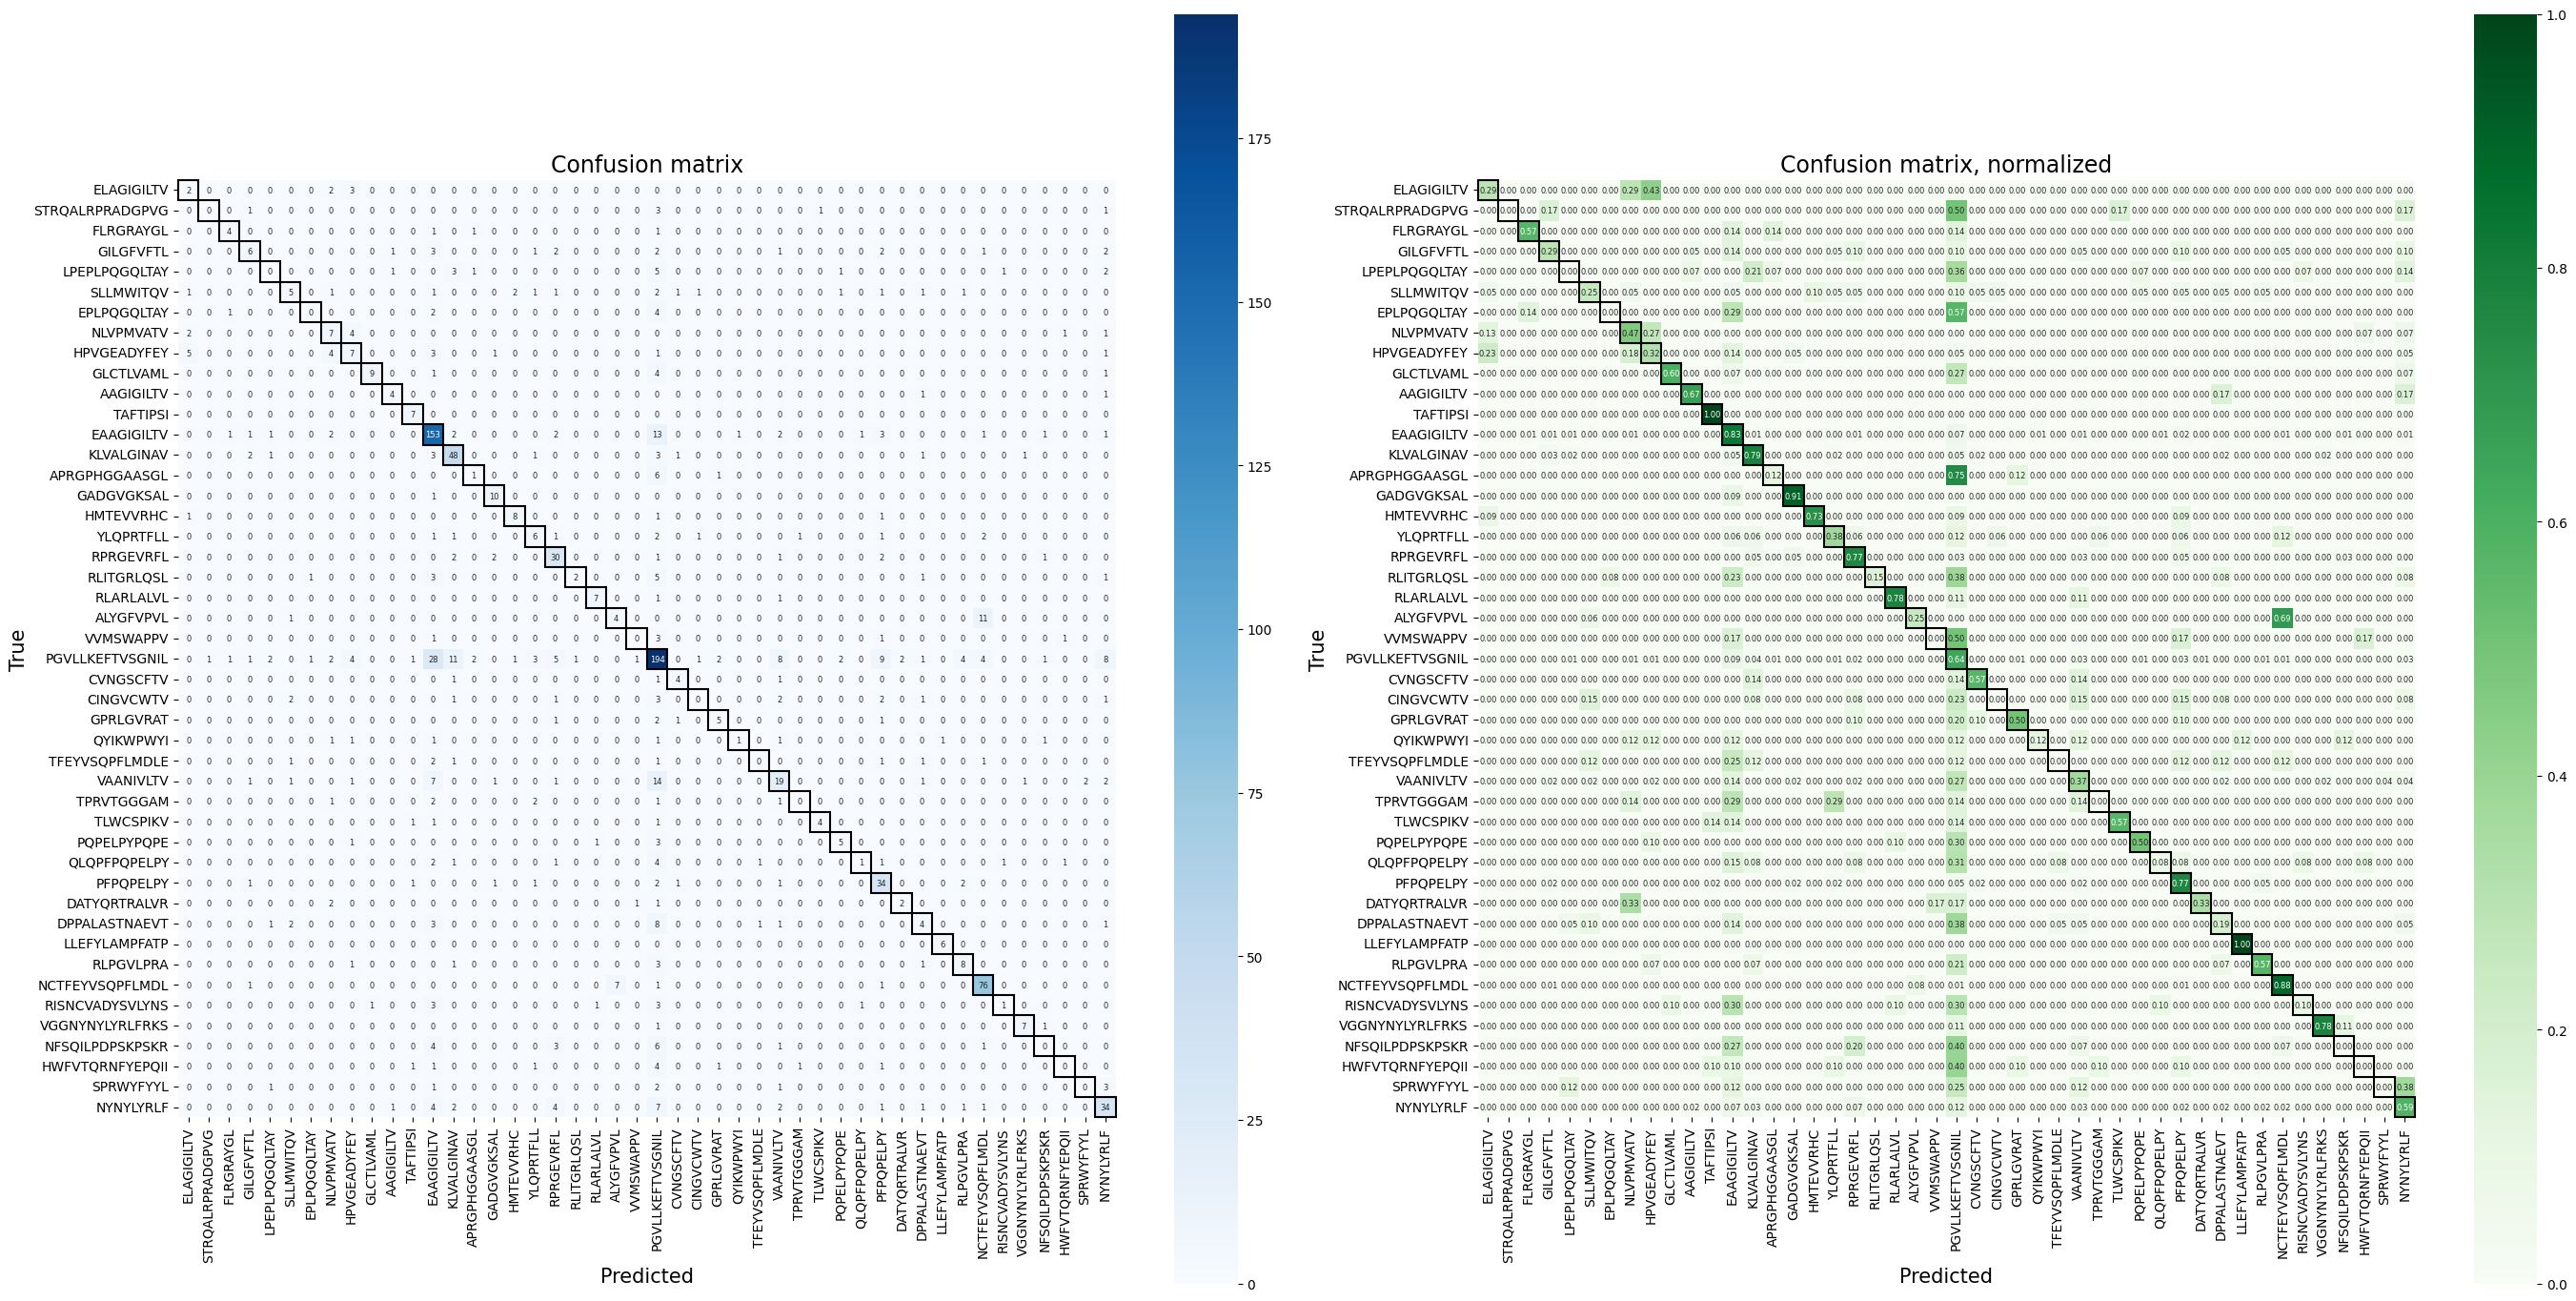

In [10]:
from matplotlib.patches import Rectangle
# get confusion matrices
epitopes = list(preds_df['y_true'].unique())
conf_mat_dash = pd.DataFrame(confusion_matrix(preds_df['y_true'], preds_df['y_pred']), columns=epitopes, index=epitopes)
conf_mat_dash_norm = pd.DataFrame(confusion_matrix(preds_df['y_true'], preds_df['y_pred'], normalize='true'), columns=epitopes, index=epitopes)

# plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28,14))
sns.set_context(font_scale=1.3)
sns.heatmap(conf_mat_dash, annot=True, cmap='Blues', fmt='', ax=axes[0], square=True, annot_kws={"size": 6}, vmin=0)
axes[0].set_xlabel('Predicted', fontsize=15)
axes[0].set_ylabel('True', fontsize=15)
axes[0].set_title('Confusion matrix', fontsize=17)

sns.heatmap(conf_mat_dash_norm, annot=True, cmap='Greens', fmt='.2f', ax=axes[1], square=True, annot_kws={"size": 6}, vmin=0)
axes[1].set_title('Confusion matrix, normalized', fontsize=17)
axes[1].set_xlabel('Predicted', fontsize=15)
axes[1].set_ylabel('True', fontsize=15)

for epi_ind in range(conf_mat_dash.shape[0]):
    axes[0].add_patch(Rectangle((epi_ind, epi_ind), 1, 1, ec='black', fc='none', lw=1.5, clip_on=False))
    axes[1].add_patch(Rectangle((epi_ind, epi_ind), 1, 1, ec='black', fc='none', lw=1.5, clip_on=False))

plt.tight_layout()

In [17]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder

# Assume X_kmer and y_kmer are your feature matrix and labels respectively
X = X_kmer  # Ensure this is a numpy array
Y = y_kmer  # Ensure this is a numpy array

# Initialize DataFrames for storing metrics
unique_labels = np.unique(Y)  # Get unique labels from the numpy array Y
metrics_cv_df = pd.DataFrame(columns=['AUC', 'Accuracy', 'Recall', 'Precision'])
auc_cv_df = pd.DataFrame(columns=unique_labels)
recall_cv_df = pd.DataFrame(columns=unique_labels)
precision_cv_df = pd.DataFrame(columns=unique_labels)

# DataFrame for storing predictions (for confusion matrix)
preds_df = pd.DataFrame(columns=['y_true', 'y_pred'], index=range(len(Y)))  # Adjust index to accommodate numpy array indexing

# Setup cross-validation
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
kfolds.get_n_splits(X, Y)

# Perform cross-validation
for train_ind, test_ind in kfolds.split(X, Y):
    # Split data using numpy indexing
    X_train, X_test = X[train_ind], X[test_ind]
    Y_train, Y_test = Y[train_ind], Y[test_ind]

    # Train model
    dt_classifier = DecisionTreeClassifier(random_state=42)
    dt_classifier.fit(X_train, Y_train)

    # Get predictions
    preds_labels = dt_classifier.predict(X_test)
    preds_prob = dt_classifier.predict_proba(X_test)

    # Store predictions in DataFrame
    preds_df.loc[test_ind, 'y_true'] = Y_test
    preds_df.loc[test_ind, 'y_pred'] = preds_labels

    # Calculate performance metrics
    Y_test_matrix = OneHotEncoder().fit(np.unique(Y).reshape(-1, 1)).transform(Y_test.reshape(-1, 1)).toarray()
    roc_auc_fold = roc_auc_score(Y_test_matrix, preds_prob, multi_class='ovr', average='macro')
    accuracy_fold = accuracy_score(Y_test, preds_labels)
    precision_fold = precision_score(Y_test, preds_labels, average='macro', zero_division=0)
    recall_fold = recall_score(Y_test, preds_labels, average='macro', zero_division=0)

    # Append data to metrics DataFrames using pd.concat
    metrics_series = pd.Series({
        'AUC': roc_auc_fold, 
        'Accuracy': accuracy_fold, 
        'Recall': recall_fold, 
        'Precision': precision_fold
    })
    metrics_cv_df = pd.concat([metrics_cv_df, pd.DataFrame([metrics_series])], ignore_index=True)

    # Calculate & store per-epitope metrics
    auc_cv_df = pd.concat([auc_cv_df, pd.DataFrame([roc_auc_score(Y_test_matrix, preds_prob, multi_class='ovr', average=None)], columns=unique_labels)], ignore_index=True)
    recall_cv_df = pd.concat([recall_cv_df, pd.DataFrame([recall_score(Y_test, preds_labels, average=None, zero_division=0)], columns=unique_labels)], ignore_index=True)
    precision_cv_df = pd.concat([precision_cv_df, pd.DataFrame([precision_score(Y_test, preds_labels, average=None, zero_division=0)], columns=unique_labels)], ignore_index=True)

metrics_cv_df


/var/folders/y8/_g3b_hys2dncxdddn9qg56100000gn/T/ipykernel_50035/4054878961.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_cv_df = pd.concat([metrics_cv_df, pd.DataFrame([metrics_series])], ignore_index=True)
/var/folders/y8/_g3b_hys2dncxdddn9qg56100000gn/T/ipykernel_50035/4054878961.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  auc_cv_df = pd.concat([auc_cv_df, pd.DataFrame([roc_auc_score(Y_test_matrix, preds_prob, multi_class='ovr', average=None)], columns=unique_labels)],

,AUC,Accuracy,Recall,Precision
0,0.624249,0.401606,0.263659,0.293640
1,0.615452,0.417671,0.244291,0.231162
2,0.660105,0.465863,0.333579,0.346087
3,0.607759,0.373494,0.230760,0.267546
4,0.639578,0.399194,0.290661,0.313174


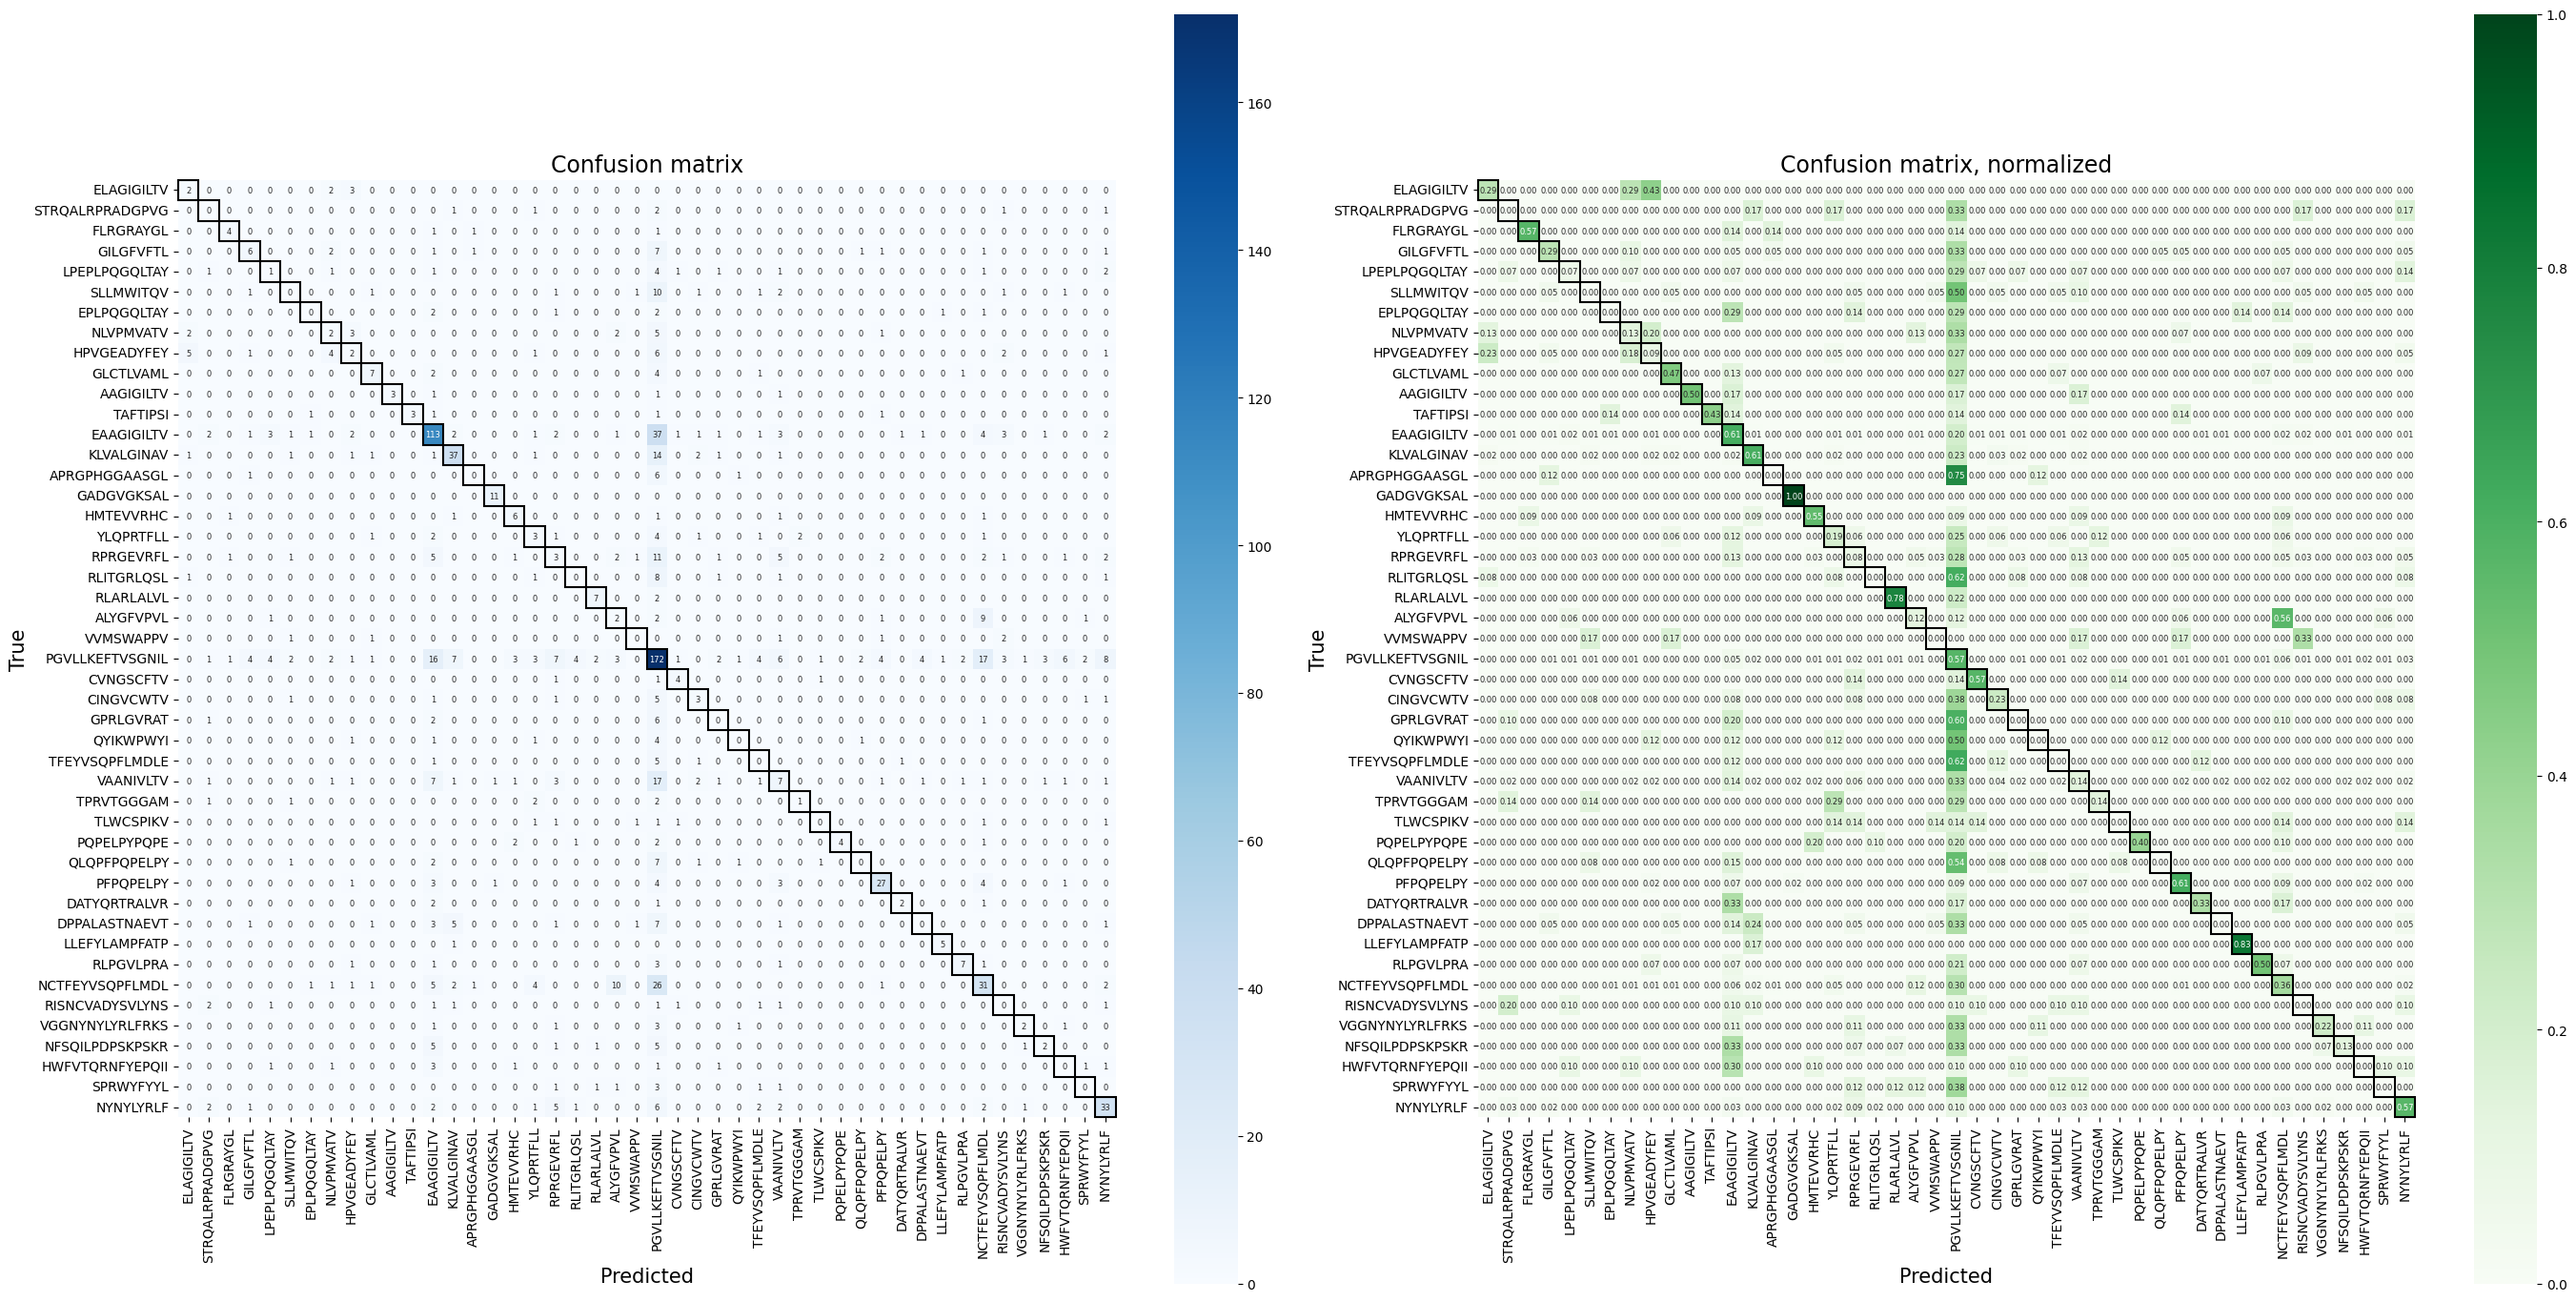

In [18]:
# get confusion matrices
epitopes = list(preds_df['y_true'].unique())
conf_mat_dash = pd.DataFrame(confusion_matrix(preds_df['y_true'], preds_df['y_pred']), columns=epitopes, index=epitopes)
conf_mat_dash_norm = pd.DataFrame(confusion_matrix(preds_df['y_true'], preds_df['y_pred'], normalize='true'), columns=epitopes, index=epitopes)

# plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28,14))
sns.set_context(font_scale=1.3)
sns.heatmap(conf_mat_dash, annot=True, cmap='Blues', fmt='', ax=axes[0], square=True, annot_kws={"size": 6}, vmin=0)
axes[0].set_xlabel('Predicted', fontsize=15)
axes[0].set_ylabel('True', fontsize=15)
axes[0].set_title('Confusion matrix', fontsize=17)

sns.heatmap(conf_mat_dash_norm, annot=True, cmap='Greens', fmt='.2f', ax=axes[1], square=True, annot_kws={"size": 6}, vmin=0)
axes[1].set_title('Confusion matrix, normalized', fontsize=17)
axes[1].set_xlabel('Predicted', fontsize=15)
axes[1].set_ylabel('True', fontsize=15)

for epi_ind in range(conf_mat_dash.shape[0]):
    axes[0].add_patch(Rectangle((epi_ind, epi_ind), 1, 1, ec='black', fc='none', lw=1.5, clip_on=False))
    axes[1].add_patch(Rectangle((epi_ind, epi_ind), 1, 1, ec='black', fc='none', lw=1.5, clip_on=False))

plt.tight_layout()

The same indexing approach as was used for the distance matrix was used in order to maintain consistency.

Th4 decisoin tree outpermed the knn on the epitope GAGGVGKSAL. The checker for unique kmers gave 'GADGVGKSAL': ['pgt', 'ssd'].